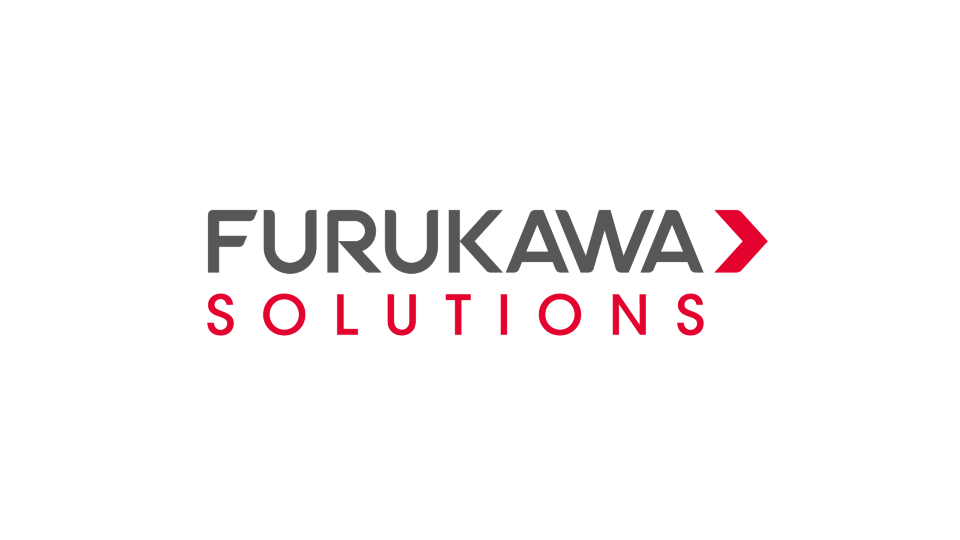<div style="width: 70%; height: 30px; background-color: #CCCCCC"><h1 style="font-family: manrope; color: black; text-align: center; vertical-align: middle; line-height: 50px"><strong>Desafio Furukawa</strong></h1></div> </br>

<div style="color: black; font-family: sans-serif">

<h5> <strong>Desafio: </strong></h5>

Você é analista em uma empresa de telecomunicações. Sua empresa vem sofrendo com uma elevada taxa de clientes que trocam de serviço e passam para seu concorrente. A diretoria gostaria de entender melhor as razões, isso é, as principais alavancas de negócio que afetam a decisão do consumidor. Além disso, deseja fazer uma campanha de marketing. 
Como recursos são limitados, a empresa gostaria de atacar apenas aqueles consumidores com alta propensão de saída. Seu desafio então é, com base no histórico de clientes do arquivo fel_churn_historico_nb_01.csv e nas boas práticas de data science, estruturar um notebook em Jupyter Python, construindo as análises e o respectivo modelo para responder as seguintes perguntas:
•	Quais são os fatores que mais influenciam a saída dos clientes?
•	Quais clientes da base fel_churn_previsão.csv que deveriam ser abordados por marketing em primeiro lugar? 
•	Quanto a empresa economiza (em número de campanhas individuais) ao utilizar o seu resultado?
•	Quão boas são suas previsões? Justifique.
•	Além das perguntas acima, quais outros insights você conseguiu extrair dessa base de dados, que são importantes de serem apresentados e relevante para a área de negocio?


<h5> <strong>Entregáveis</strong></h5>

1)	Elabore seu notebook estruturando cada capítulo como uma fase do processo de data science explicando seu raciocínio e ressaltando as conclusões de cada etapa;
2)	Crie um storytelling (a ferramenta ou técnica de apresentação pode ser de sua escolha), para explicar suas conclusões e respostas para as perguntas acima. 
De forma geral, essa apresentação não deve ter uma linguagem técnica, pois você estaria apresentando para a área de negócio suas conclusões. Fique á vontade para adicionar considerações gerais, percebidas durante a análise da base;
3)	Envie o material por e-mail do item 1 e 2 até dia 02-09 às 08:00 horas e apresentá-lo para equipe Furukawa no horário agendado pela Icon. Lembrando que essa fase será: De 20 minutos de apresentação do item 2 e 40 de conversa com o time da área de dados. 

</div>
<br>


## Entendendo os dados
Começamos carregando as bibliotecas de suporte para análise dos dados.

In [1603]:
#libs
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Modelo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import sensitivity_score, specificity_score
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from imblearn.metrics import sensitivity_score, specificity_score

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Configuração do Notebook
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

Dados

In [1604]:
dados = pd.read_csv(r"fel_churn_historico_nb_01.csv")
dados.sample(5)

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,Churn,ClasseTempoContrato
1359,4607-CHPCA,Masculino,False,True,True,25,True,False,Fibra,False,False,False,False,True,True,Anual,True,Conta Eletronica,90.40,2178.60,True,Classe_24_48
204,7233-DRTRF,Masculino,False,True,False,63,True,True,Fibra,False,True,True,False,True,True,Mensal,True,Conta Eletronica,102.40,6444.05,False,Classe_60_99
1121,9895-VFOXH,Feminino,False,False,False,1,False,Sem Telefone,DSL,False,False,False,False,False,False,Mensal,False,Conta Papel,24.40,24.40,False,Classe_00_12
255,8746-OQQRW,Masculino,False,False,False,4,True,True,Sem Internet,False,False,False,False,False,False,Mensal,False,Conta Papel,25.25,101.90,False,Classe_00_12
1090,1465-WCZVT,Feminino,False,True,True,3,True,False,Sem Internet,False,False,False,False,False,False,Mensal,False,Conta Papel,19.65,60.65,False,Classe_00_12


In [1605]:
def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index, 
                                data[columns].dtypes, 
                                data[columns].nunique(), 
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100), 
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

In [1606]:
check_cols(dados, dados.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,ID,object,5274,0,0.0
1,CustoTotal,float64,4961,0,0.0
2,CustoMensal,float64,1460,0,0.0
3,MetodoPagto,object,4,0,0.0
4,ContaDigital,bool,2,0,0.0
5,TipoContrato,object,3,0,0.0
6,Filmes,bool,2,0,0.0
7,TV,bool,2,0,0.0
8,Suporte,bool,2,0,0.0
9,Seguro,bool,2,0,0.0


Temos uma base com mais de 5 mil registros, tempos de contrato por classes e uma serie de variaveis categoricas nsobre nossos clientes. Nenhum NaN por coluna.

In [1607]:
# separando as variaveis para fazer graficos

cat_vars = ['Sexo', 'Idoso', 'Casado', 'Dependentes', 'Telefone', 'LinhasMultiplas', 
               'Internet', 'AntiVirus', 'Backup', 'Seguro', 'Suporte', 'TV', 'Filmes', 'TipoContrato', 'ContaDigital']

num_vars = ['TempoContrato', 'CustoMensal', 'CustoTotal']

cat_vars_2 = ['Sexo', 'Idoso', 'Casado', 'Dependentes', 'Telefone', 'LinhasMultiplas', 
               'Internet', 'AntiVirus', 'Backup', 'Seguro', 'Suporte', 'TV', 'Filmes', 'TipoContrato', 'ContaDigital','MetodoPagto', 'ClasseTempoContrato']

Para analisarmos os dados, podemos separar entre os consumidores que ficaram (Churn = False) e que saíram (Churn = True) no histórico.

In [1608]:
resumo_churn = dados.loc[~dados.Churn, cat_vars].describe().T
resumo_churn

,count,unique,top,freq
Sexo,3864,2,Masculino,1940
Idoso,3864,2,False,3365
Casado,3864,2,True,2059
Dependentes,3864,2,False,2519
Telefone,3864,2,True,3468
LinhasMultiplas,3864,3,False,1883
Internet,3864,3,DSL,1468
AntiVirus,3864,2,False,2594
Backup,3864,2,False,2452
Seguro,3864,2,False,2473


In [1609]:
resumo_nao_churn = dados.loc[dados.Churn, cat_vars].describe().T
resumo_nao_churn

,count,unique,top,freq
Sexo,1410,2,Feminino,712
Idoso,1410,2,False,1068
Casado,1410,2,False,913
Dependentes,1410,2,False,1169
Telefone,1410,2,True,1284
LinhasMultiplas,1410,3,False,658
Internet,1410,3,Fibra,973
AntiVirus,1410,2,False,1186
Backup,1410,2,False,1019
Seguro,1410,2,False,996


Para facilitar a análise podemos concatenar os dois resumos.

In [1610]:
resumo_cat = pd.concat([resumo_churn, resumo_nao_churn], axis = 1)
resumo_cat

,count,unique,top,freq,count,unique,top,freq
Sexo,3864,2,Masculino,1940,1410,2,Feminino,712
Idoso,3864,2,False,3365,1410,2,False,1068
Casado,3864,2,True,2059,1410,2,False,913
Dependentes,3864,2,False,2519,1410,2,False,1169
Telefone,3864,2,True,3468,1410,2,True,1284
LinhasMultiplas,3864,3,False,1883,1410,3,False,658
Internet,3864,3,DSL,1468,1410,3,Fibra,973
AntiVirus,3864,2,False,2594,1410,2,False,1186
Backup,3864,2,False,2452,1410,2,False,1019
Seguro,3864,2,False,2473,1410,2,False,996


Frequencia percentual dos valores mais frequentes nos dois casos:

In [1611]:
resumo_cat['% Não Churn'] = resumo_cat.iloc[:,3] / resumo_cat.iloc[:,0]
resumo_cat['% Churn'] = resumo_cat.iloc[:,7] / resumo_cat.iloc[:,4]

In [1612]:
resumo_cat

,count,unique,top,freq,count,unique,top,freq,% Não Churn,% Churn
Sexo,3864,2,Masculino,1940,1410,2,Feminino,712,0.50207,0.504965
Idoso,3864,2,False,3365,1410,2,False,1068,0.870859,0.757447
Casado,3864,2,True,2059,1410,2,False,913,0.532867,0.647518
Dependentes,3864,2,False,2519,1410,2,False,1169,0.651915,0.829078
Telefone,3864,2,True,3468,1410,2,True,1284,0.897516,0.910638
LinhasMultiplas,3864,3,False,1883,1410,3,False,658,0.487319,0.466667
Internet,3864,3,DSL,1468,1410,3,Fibra,973,0.379917,0.690071
AntiVirus,3864,2,False,2594,1410,2,False,1186,0.671325,0.841135
Backup,3864,2,False,2452,1410,2,False,1019,0.634576,0.722695
Seguro,3864,2,False,2473,1410,2,False,996,0.64001,0.706383


As classes parecem bem balanceadas nos registros dessa base. 

In [1613]:
dados.groupby('Churn').describe().T

Churn                      False        True 
TempoContrato count  3864.000000  1410.000000
              mean     37.993530    17.842553
              std      24.088181    19.281064
              min       1.000000     1.000000
              25%      15.000000     2.000000
              50%      38.000000    10.000000
              75%      61.000000    28.000000
              max      72.000000    72.000000
CustoMensal   count  3864.000000  1410.000000
              mean     61.054878    74.494255
              std      31.032461    24.535128
              min      18.250000    18.850000
              25%      25.050000    55.725000
              50%      64.125000    79.700000
              75%      88.050000    94.250000
              max     118.750000   118.350000
CustoTotal    count  3864.000000  1410.000000
              mean   2561.983424  1511.516738
              std    2319.465611  1858.057591
              min      18.800000    18.850000
              25%     594.612500   131.050000
              50%    1688.150000   726.675000
              75%    4297.687500  2290.212500
              max    8672.450000  8109.800000

1. Tempo de Contrato:
Clientes que não churnaram (Churn = False):

Média: 37.99 meses (~3 anos e 2 meses).
Clientes fiéis tendem a permanecer mais tempo com a empresa.
Mediana: 38 meses.
Metade dos clientes fiéis tem contratos com pelo menos 3 anos e 2 meses.
Distribuição:
25% dos clientes têm menos de 15 meses de contrato.
75% têm mais de 28 meses.
Variância: Relativamente estável com um desvio padrão de 24.09 meses.
STD: 24.09
Existe uma dispercao consideravel no tempo de contrato de clientes fieis. 
A alta variância reflete uma base de clientes diversificada em termos de fidelidade.

Clientes que churnaram (Churn = True):

Média: 17.84 meses (~1 ano e 5 meses).
Esses clientes permanecem menos tempo antes de cancelar.
Mediana: 10 meses.
Metade desses clientes deixa a empresa antes de completar 1 ano.
Distribuição:
25% têm menos de 2 meses de contrato.
Conclusão: Um tempo de contrato curto está correlacionado com uma maior probabilidade de churn.
STD: 19.28
A dispercao é um pouco menor entre clientes que deram churn. Isso indica que existe um grupo menor que ficou por períodos mais longos.

2. Custo Mensal:
Clientes que não churnaram (Churn = False):

Média: $61.05 por mês.
Clientes fiéis pagam um valor mensal menor em media.
Mediana: $64.12.
A maior parte dos clientes fiéis está no intervalo de $25.05 a $88.05.
STD 31.03:
A dispersão no custo mensal é alta, o que indica que clientes fiéis possuem um amplo intervalo de valores de planos ou serviços adicionais.

Clientes que churnaram (Churn = True):

Média: $74.49 por mês.
Clientes que churnaram têm custos mensais significativamente mais altos.
Mediana: $79.70.
25% dos clientes churnados pagam mais de $94.25 por mês.
O custo de clientes que churnaram é mais alto do que os clientes mais fiéis.
std 24.53:
Para clientes que churnaram, a dispersão é menor em relação aos fiéis. Isso indica que os custos mensais desses clientes estão mais concentrados em uma faixa alta (como mostrado pela média de $74.49).

3. Custo Total:
Clientes que não churnaram (Churn = False):

Média: $2561.98.
Os clientes fiéis geram maior receita acumulada, pois têm contratos mais longos.
Mediana: $1688.15.
25% dos clientes fiéis geram mais de $4297.69 de receita total.
STD 2319.47:
O desvio padrão extremamente alto reflete a ampla variação nos contratos e receita acumulada. Alguns clientes geram receita muito alta (até $8672.45), enquanto outros geram menos de $1000.

Clientes que churnaram (Churn = True):
Média: $1511.52.
Clientes churnados contribuem com uma receita acumulada menor devido ao tempo reduzido de contrato.
Mediana: $726.67.
A maior parte dos clientes churnados gera menos de $2290.21.
Clientes churnados representam uma oportunidade perdida de receita de longo prazo.
STD 1858.06:
O desvio padrão é ainda alto, mas menor que o dos clientes fiéis. Isso indica que, embora existam clientes churnados com altos custos totais, a maioria está em faixas inferiores.

Foco nos primeiros meses de contrato, já que muitos clientes churnam antes dos 10 meses. Isso inclui:

Melhor suporte ao cliente.
Incentivos de retenção no início do contrato.

Embora estas tabelas sejam interessantes, elas oferecem pouca informação detalhada sobre as alavancas de negócio e são de difícil interpretação. Podemos então complementar nossa análise com uma análise gráfica.

## Análise Gráfica Exploratória

In [1614]:
#esquema de cores furukawea
furukawa_colors = ["#CCCCCC", "#333333", "#E30613"]

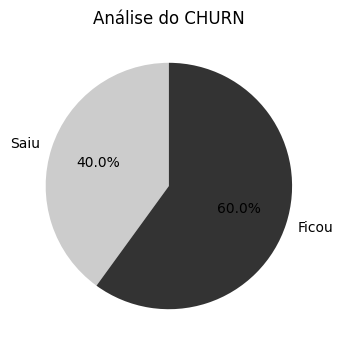

In [1615]:
labels = ['Saiu', 'Ficou']  
values = [40, 60]  

plt.figure(figsize=(6, 4))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=furukawa_colors[:len(values)])
plt.title('Análise do CHURN')

plt.show()


Como já foi visto, temos classes relativa,mente  balanceadas.

### Análise de Variáveis Categóricas

In [1616]:
def compare_pie(data_churn, data_no_churn, variable, title_churn, title_no_churn, size=(None, 400)):
    churn_counts = data_churn[variable].value_counts()
    no_churn_counts = data_no_churn[variable].value_counts()

    labels = churn_counts.index.tolist()  # Assume rótulos iguais para ambos
    values_churn = churn_counts.values
    values_no_churn = no_churn_counts.values

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Gráficos lado a lado

    axes[0].pie(values_churn, labels=labels, autopct='%1.1f%%', startangle=90, colors=furukawa_colors[:len(values_churn)])
    axes[0].set_title(title_churn)

    axes[1].pie(values_no_churn, labels=labels, autopct='%1.1f%%', startangle=90, colors=furukawa_colors[:len(values_no_churn)])
    axes[1].set_title(title_no_churn)

    plt.suptitle(f"Comparação de {variable} - {title_churn} vs {title_no_churn}", fontsize=14)
    plt.tight_layout()
    plt.show()

def compare_bar(data_churn, data_no_churn, variable, title):
    churn_counts = data_churn[variable].value_counts(normalize=True) * 100  
    no_churn_counts = data_no_churn[variable].value_counts(normalize=True) * 100 


    comparison_df = pd.DataFrame({
        "Saiu (%)": churn_counts,
        "Ficou (%)": no_churn_counts
    }).fillna(0)  


    comparison_df.plot(kind="bar", figsize=(10, 6), color=["#E30613", "#CCCCCC"])
    plt.title(f"Comparação de {title} - Saiu vs Ficou", fontsize=14)
    plt.ylabel("Porcentagem (%)")
    plt.xlabel(variable)
    plt.xticks(rotation=45)
    plt.legend(title="Status do Cliente")
    plt.tight_layout()
    plt.show()

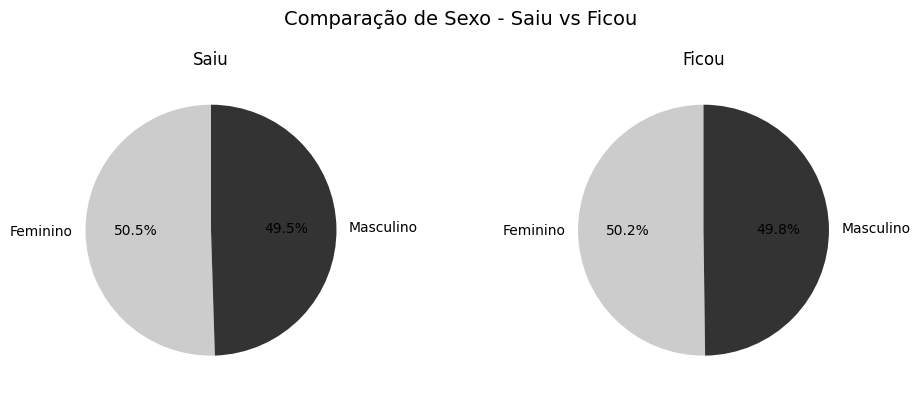

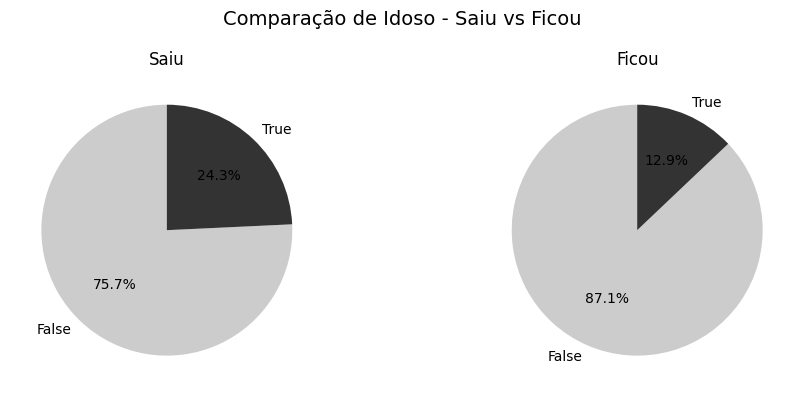

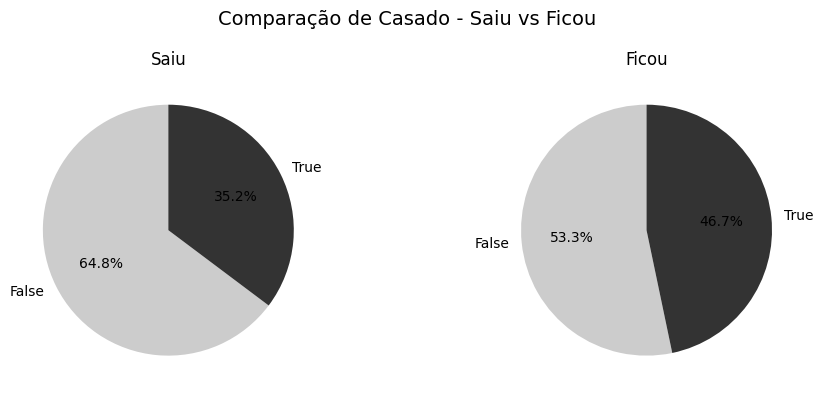

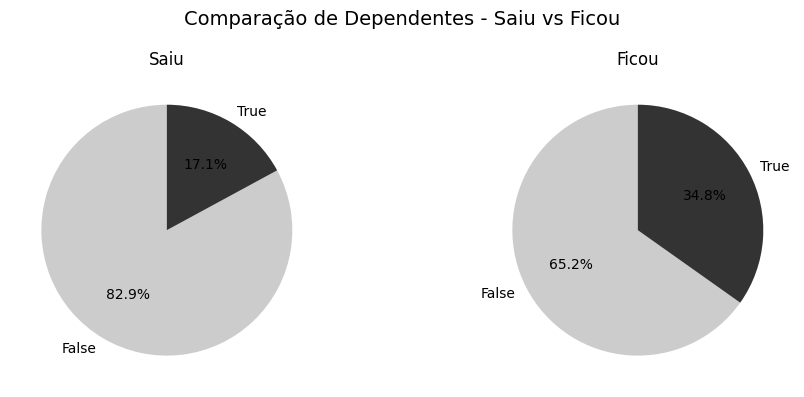

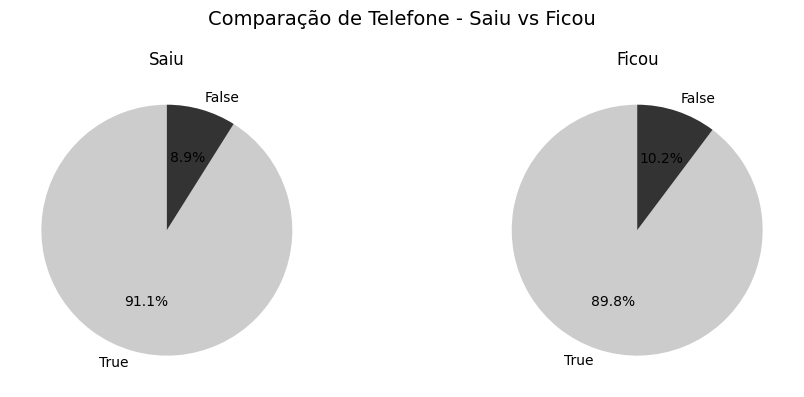

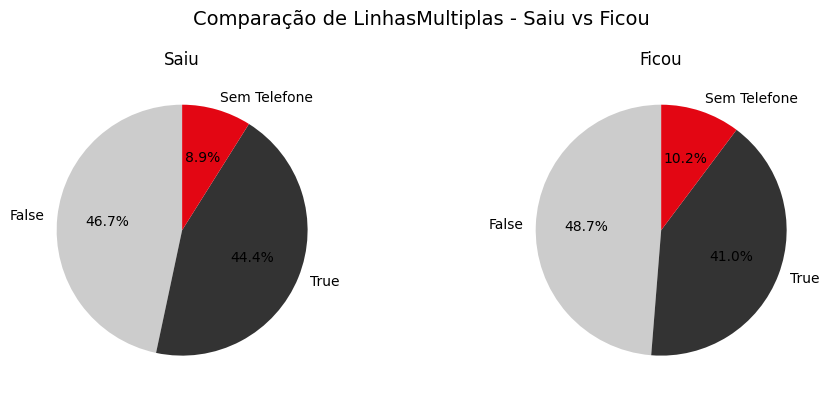

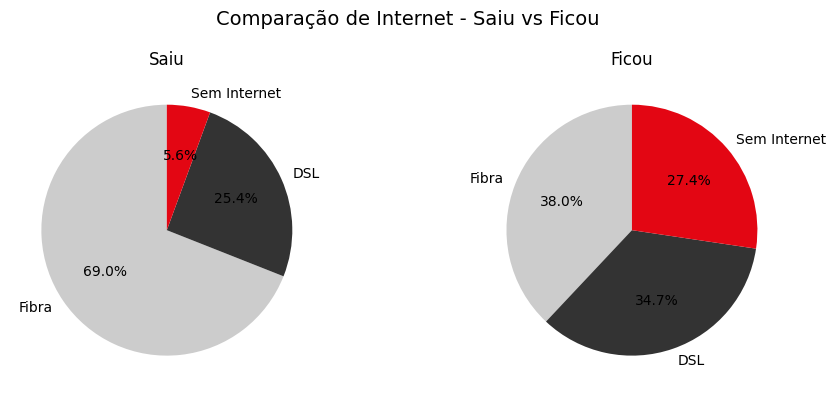

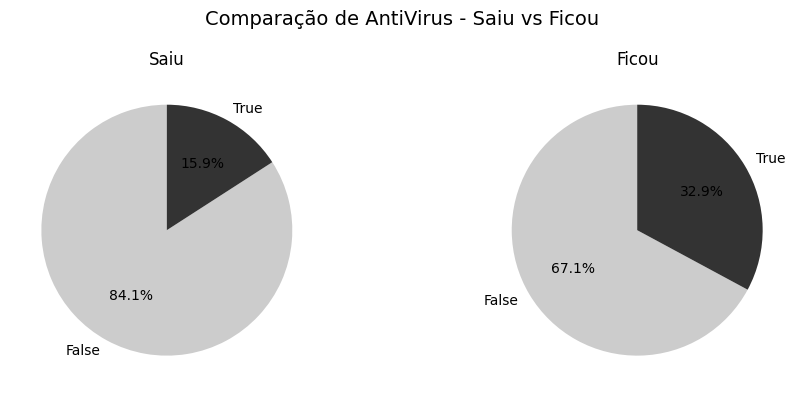

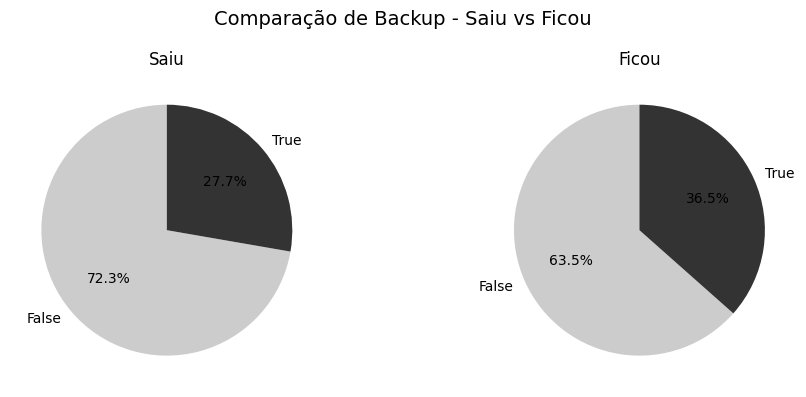

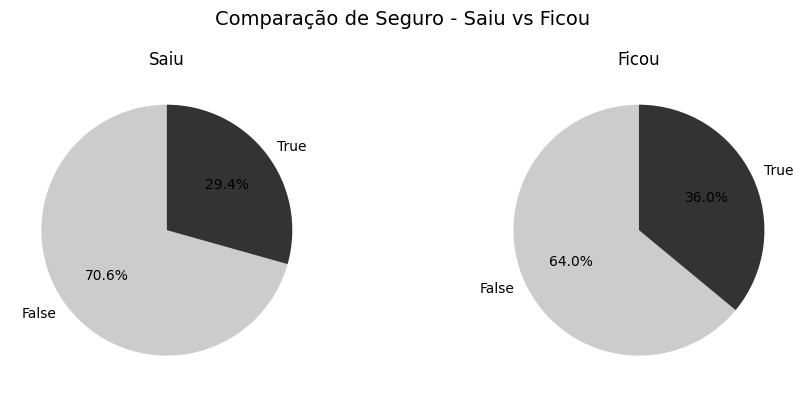

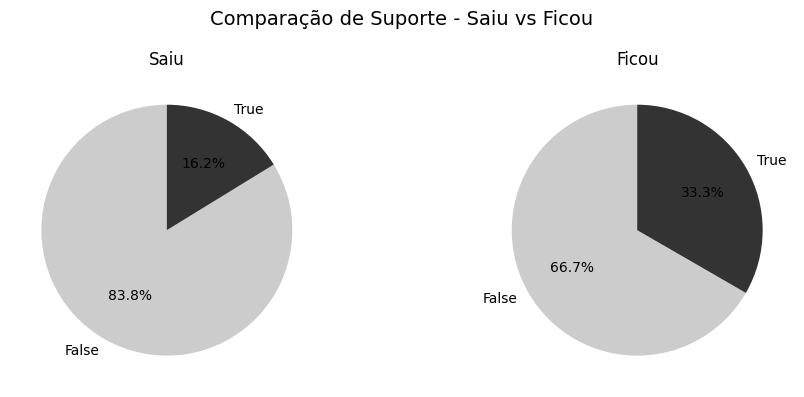

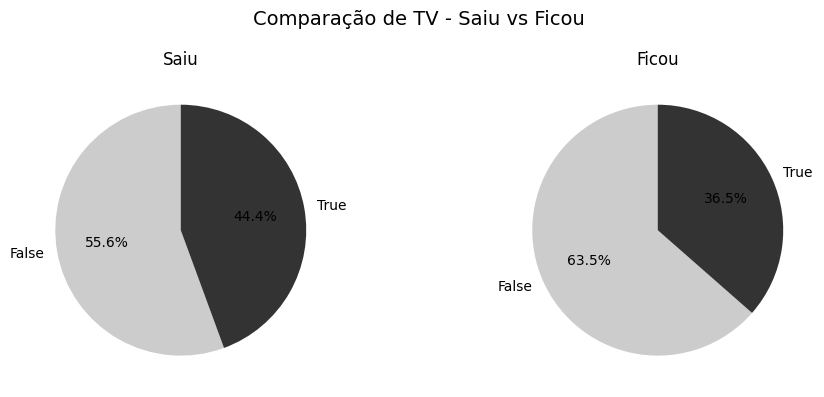

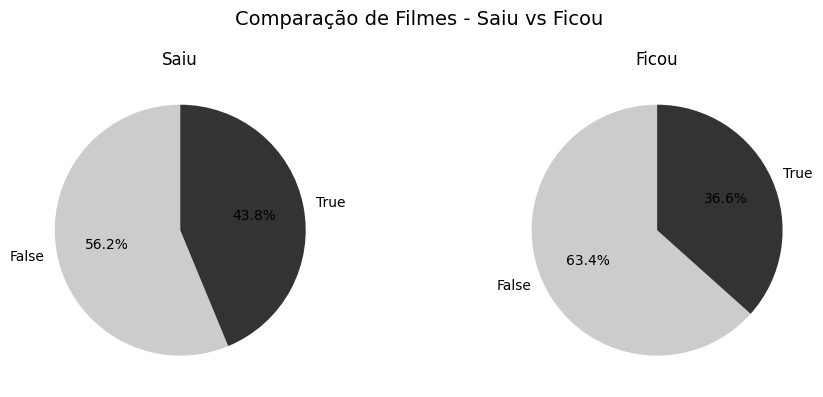

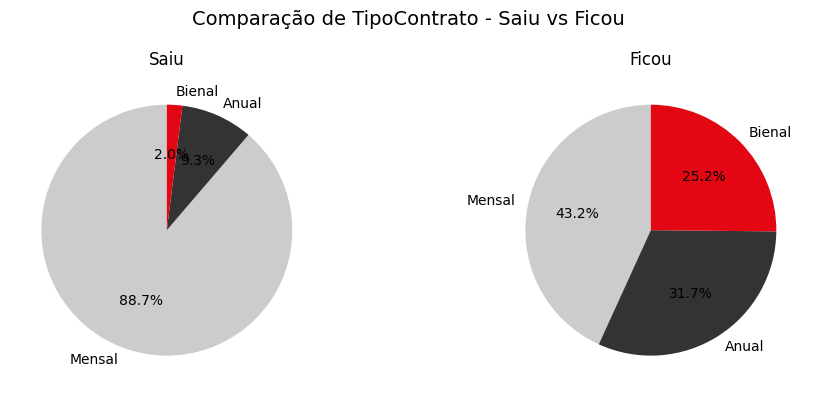

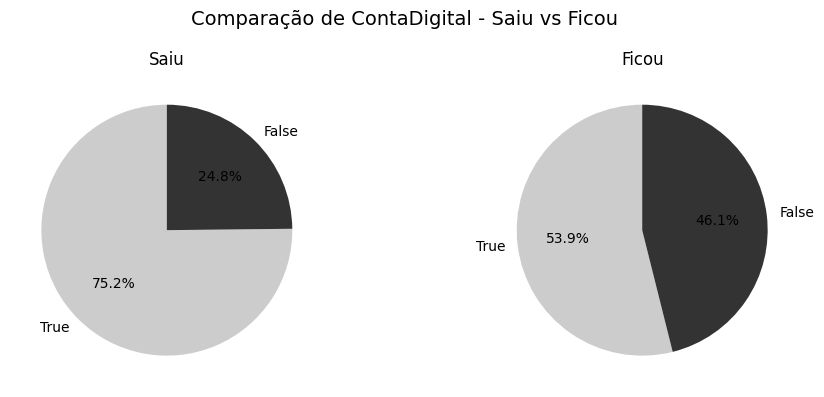

In [1617]:
for var in cat_vars:
    compare_pie(dados[dados['Churn'] == 1], dados[dados['Churn'] == 0], var, "Saiu", "Ficou", size=(None, 400))

O publico feminino apresenta maior propenção a sair, porém esse numero nao é estatisticamente relevante nesse caso. </br>
Pessoas casadas costumam ficar mais tempo que pessoas nao casadas, assim como pessoas que declaram ter dependentes</br>
Pessoas que possuem fibra otima (internet) sao maioria na base dos clientes que sairam, enquanto clientes sem internet apresentam 27% dos clientes fieis.</br>
Pessoas que sairam tiveram menos suporte do que pessoas que ficaram.</br>
Clientes que possuem contrato mensal sao a maioria na massa de clientes que sairam. Já na massa de clientes que ficaram, os percentuais entre os contratos é mais equilibrado.</br>

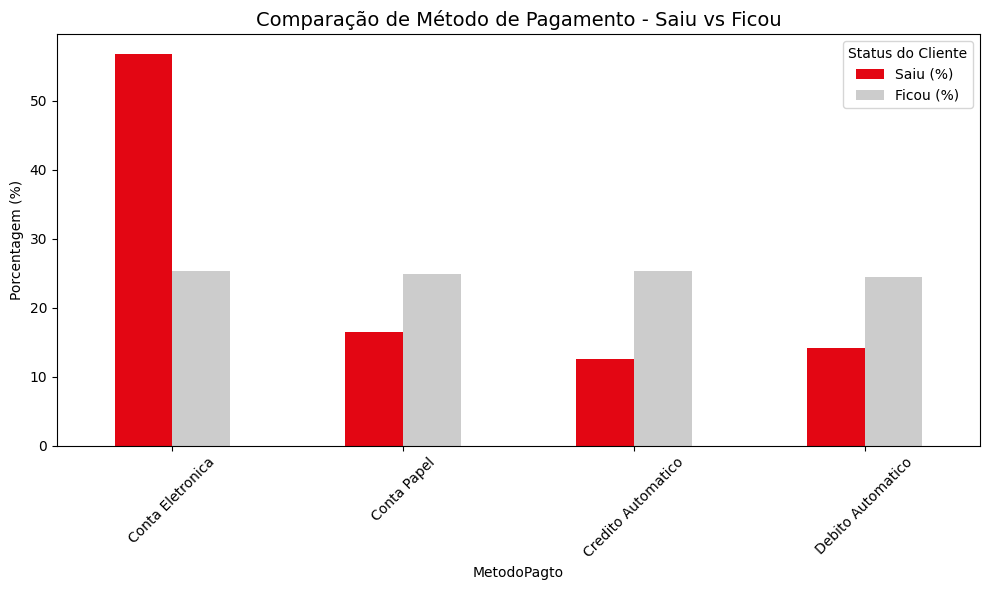

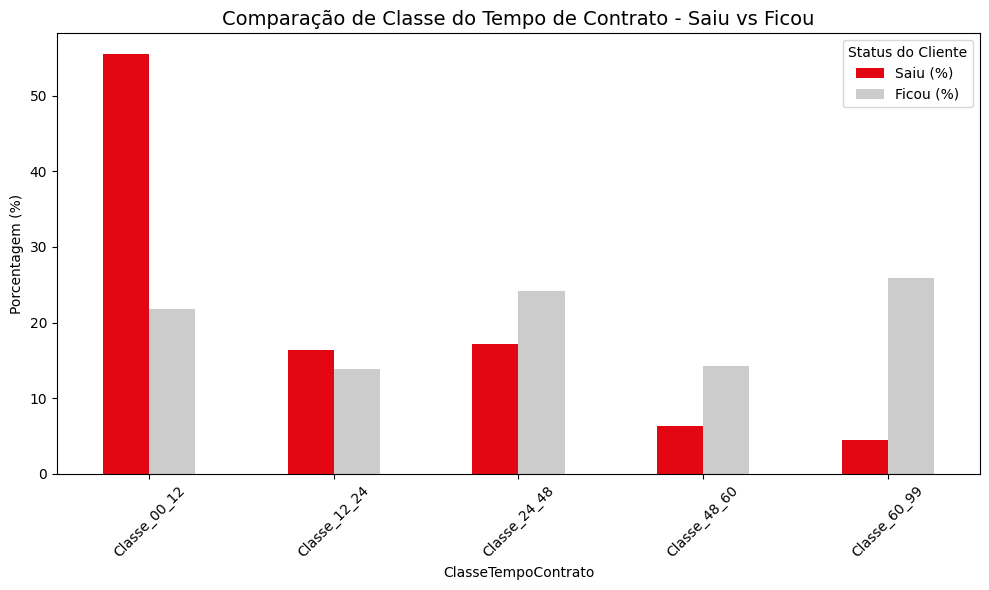

In [1618]:
dados_churn = dados[dados['Churn'] == 1]
dados_ficou = dados[dados['Churn'] == 0]

compare_bar(dados_churn, dados_ficou, "MetodoPagto", "Método de Pagamento")
compare_bar(dados_churn, dados_ficou, "ClasseTempoContrato", "Classe do Tempo de Contrato")

### Análise das Variáveis Numéricas

In [1619]:
furukawa_colors = ["#CCCCCC", "#E30613", "#333333", "#000000"]  
def plot_histograms(data_churn, data_no_churn, variables, labels, size=(None, 400)):
    for var in variables:
        plt.figure(figsize=(10, 4)) 
        
        plt.hist(
            data_churn[var], bins=15, alpha=0.8, color=furukawa_colors[1], label=labels[0]
        )
        
        plt.hist(
            data_no_churn[var], bins=15, alpha=0.8, color=furukawa_colors[0], label=labels[1]
        )
        
        plt.title(f"Distribuição de {var} - {labels[0]} vs {labels[1]}", fontsize=14)
        plt.xlabel(var, fontsize=12)
        plt.ylabel("Frequência", fontsize=12)
        plt.legend(title="Status do Cliente", fontsize=10)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        
        plt.show()

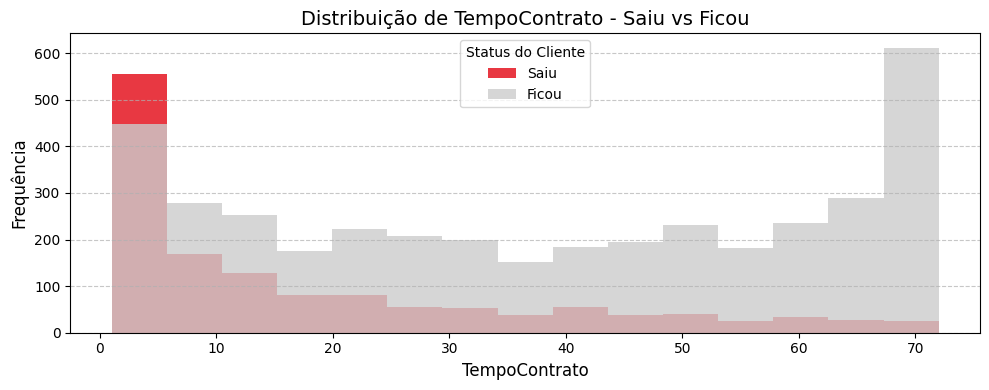

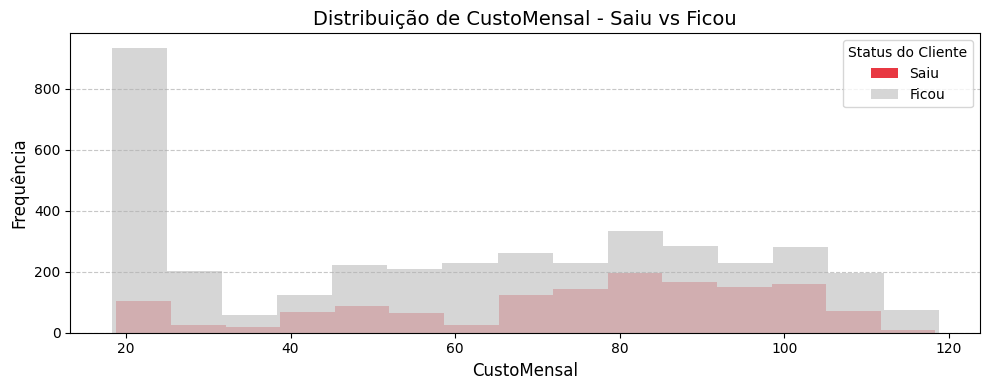

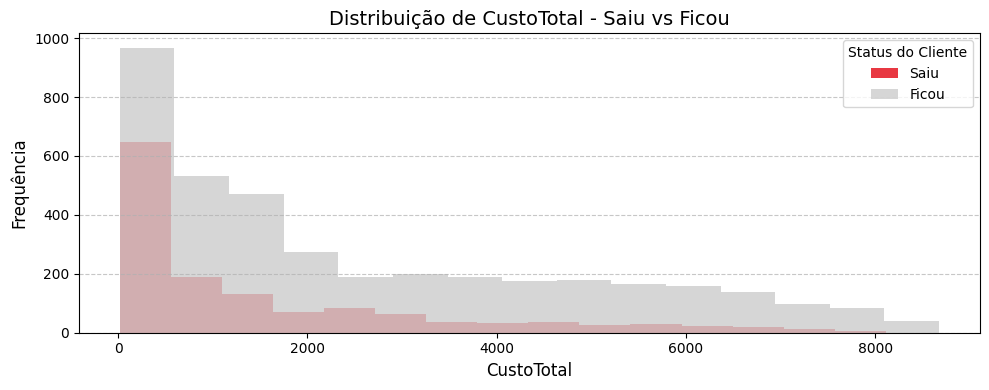

In [1620]:
plot_histograms(
    dados[dados['Churn'] == 1],  
    dados[dados['Churn'] == 0],  
    num_vars,
    ['Saiu', 'Ficou']
)

Muito importante a análise de tempo nde contrato dos clientes que churnaram e que ficaram, visto que parece ser um fator de extrema importancia no comportamento do cliente que sai. </br>
O custo MENSAL por cliente que fica é mais alto do que o custo de manutenção de cliente que sai, mas o custo TOTAL por cliente que sai também ganha destaque. mesmo assim o cliente que fica tambem apresenta um custo alto total.

In [1621]:
dados.loc[dados.CustoTotal < 200].groupby('Churn').describe().T

Churn                     False       True 
TempoContrato count  444.000000  437.000000
              mean     3.090090    1.622426
              std      2.554329    1.282111
              min      1.000000    1.000000
              25%      1.000000    1.000000
              50%      2.000000    1.000000
              75%      4.000000    2.000000
              max     12.000000   11.000000
CustoMensal   count  444.000000  437.000000
              mean    34.434459   57.443478
              std     20.377447   23.843808
              min     18.800000   18.850000
              25%     19.900000   40.400000
              50%     20.675000   60.000000
              75%     48.487500   75.800000
              max     97.100000  102.450000
CustoTotal    count  444.000000  437.000000
              mean    85.807432   83.489359
              std     54.767776   46.739217
              min     18.800000   18.850000
              25%     43.837500   49.950000
              50%     73.775000   74.700000
              75%    130.175000  100.800000
              max    199.850000  198.000000

### Analisando Correlações entre Variáveis Numéricas

In [1622]:
variables = ['CustoMensal', 'CustoTotal', 'TempoContrato']
target = 'Churn'

dados_corr = pd.concat([dados[variables], dados[target]], axis=1)

In [1623]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5274 non-null   object 
 1   Sexo                 5274 non-null   object 
 2   Idoso                5274 non-null   bool   
 3   Casado               5274 non-null   bool   
 4   Dependentes          5274 non-null   bool   
 5   TempoContrato        5274 non-null   int64  
 6   Telefone             5274 non-null   bool   
 7   LinhasMultiplas      5274 non-null   object 
 8   Internet             5274 non-null   object 
 9   AntiVirus            5274 non-null   bool   
 10  Backup               5274 non-null   bool   
 11  Seguro               5274 non-null   bool   
 12  Suporte              5274 non-null   bool   
 13  TV                   5274 non-null   bool   
 14  Filmes               5274 non-null   bool   
 15  TipoContrato         5274 non-null   o

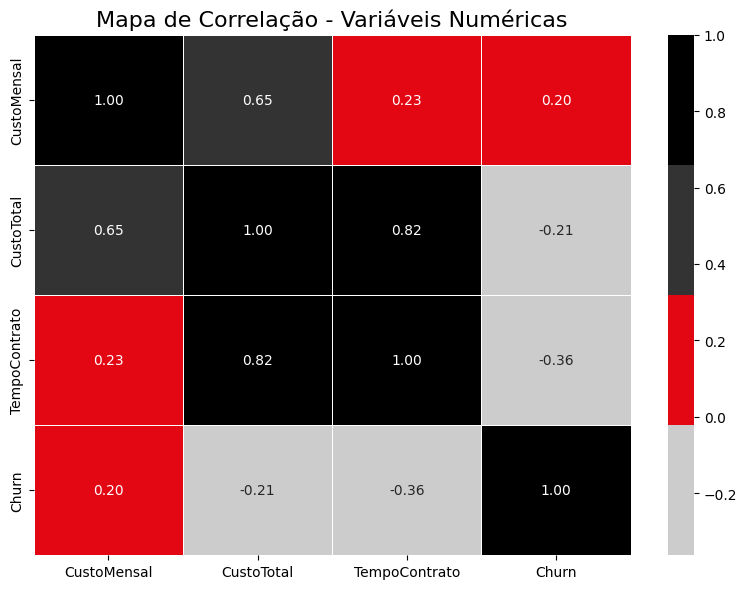

In [1624]:
dados_corr = dados_corr.dropna()

correlation_matrix = dados_corr.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    correlation_matrix, 
    annot=True,  
    fmt=".2f",   
    cmap=furukawa_colors,  
    linewidths=0.5
)


plt.title("Mapa de Correlação - Variáveis Numéricas", fontsize=16)
plt.tight_layout()

# Exibir o gráfico
plt.show()

Como visto, a correlacao negativa entre o tempo de contrato e o churn é negativa, quanto maior um, menor o outro e a correlacao positiva entre custo total e mensal é alta, pois uma deriva da outra.</br>

### Análise das Faixas de Contrato
Como a variável de tempo de contrato parece influenciar bastante a decisão, parece interessante a entender melhor essa variavel e seu comportamento. 

In [1625]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').ID.nunique().reset_index()
freq_tab_01.columns = ['Tempo Contrato', 'Clientes']

freq_tab_01

,Tempo Contrato,Clientes
0,Classe_00_12,782
1,Classe_12_24,231
2,Classe_24_48,243
3,Classe_48_60,90
4,Classe_60_99,64


In [1626]:
freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').ID.nunique().reset_index()
freq_tab_02.columns = ['Tempo Contrato', 'Clientes']

freq_tab_02

,Tempo Contrato,Clientes
0,Classe_00_12,841
1,Classe_12_24,536
2,Classe_24_48,936
3,Classe_48_60,549
4,Classe_60_99,1002


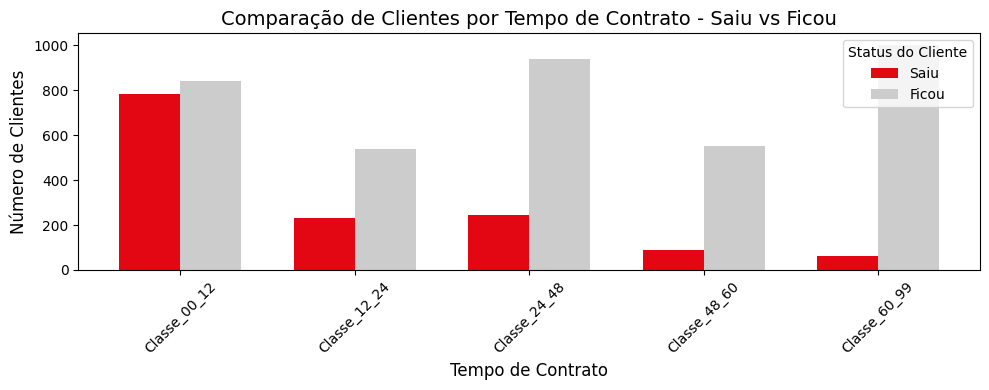

In [1627]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="Tempo Contrato", how="outer", suffixes=("_Saiu", "_Ficou")
).fillna(0)  


merged_data = merged_data.sort_values(by="Tempo Contrato")  
x_labels = merged_data["Tempo Contrato"]
clientes_saiu = merged_data["Clientes_Saiu"]
clientes_ficou = merged_data["Clientes_Ficou"]

plt.figure(figsize=(10, 4))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, clientes_saiu, bar_width, label="Saiu", color="#E30613")  
plt.bar([i + bar_width for i in x], clientes_ficou, bar_width, label="Ficou", color="#CCCCCC")  

plt.xlabel("Tempo de Contrato", fontsize=12)
plt.ylabel("Número de Clientes", fontsize=12)
plt.title("Comparação de Clientes por Tempo de Contrato - Saiu vs Ficou", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Status do Cliente")
plt.tight_layout()

plt.show()

Grande parte do pessoal sai nos 12 primeiros meses. Cabe uma açao de marketing para tentar garantir que os clientes, no primeiro ano de relacionamento, tenha maior assistencia. 

In [1628]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').CustoMensal.mean().reset_index()
freq_tab_01.columns = ['Tempo Contrato', 'Custo Médio Mensal']

freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').CustoMensal.mean().reset_index()
freq_tab_02.columns = ['Tempo Contrato', 'Custo Médio Mensal']

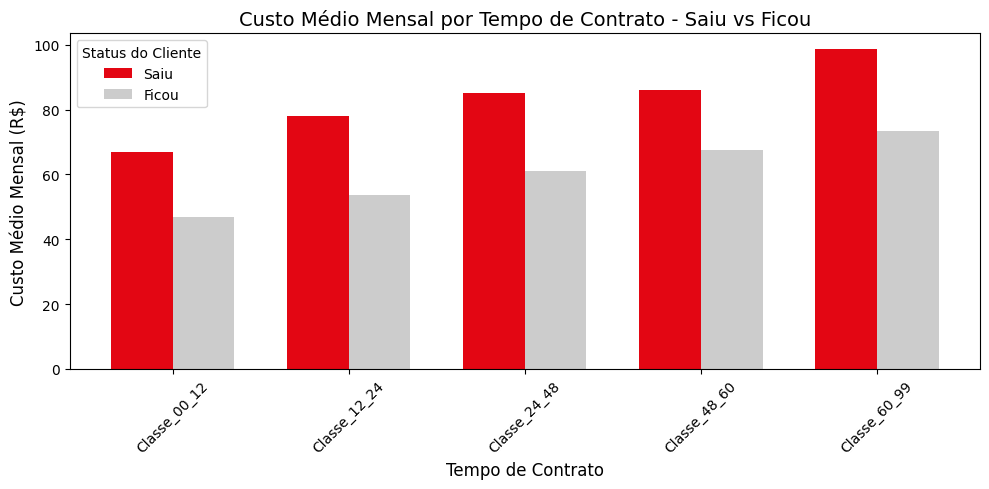

In [1629]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="Tempo Contrato", how="outer", suffixes=("_Saiu", "_Ficou")
).fillna(0)  

merged_data = merged_data.sort_values(by="Tempo Contrato") 
x_labels = merged_data["Tempo Contrato"]
custo_saiu = merged_data["Custo Médio Mensal_Saiu"]
custo_ficou = merged_data["Custo Médio Mensal_Ficou"]


plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, custo_saiu, bar_width, label="Saiu", color="#E30613")  
plt.bar([i + bar_width for i in x], custo_ficou, bar_width, label="Ficou", color="#CCCCCC")  # Cinza claro

plt.xlabel("Tempo de Contrato", fontsize=12)
plt.ylabel("Custo Médio Mensal (R$)", fontsize=12)
plt.title("Custo Médio Mensal por Tempo de Contrato - Saiu vs Ficou", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Status do Cliente")
plt.tight_layout()

plt.show()

O custo medio mensal por cliente que saiu, independente da faixa de tempo de relacionamento com a empresa, é mais alto. O custo certamente influencia na desicao de churn do cliente.

In [1630]:
freq_tab_01  =  dados[dados.Churn].groupby('ClasseTempoContrato').CustoTotal.mean().reset_index()
freq_tab_01.columns = ['Tempo Contrato', 'Custo Médio Total']

freq_tab_02  =  dados[~dados.Churn].groupby('ClasseTempoContrato').CustoTotal.mean().reset_index()
freq_tab_02.columns = ['Tempo Contrato', 'Custo Médio Total']

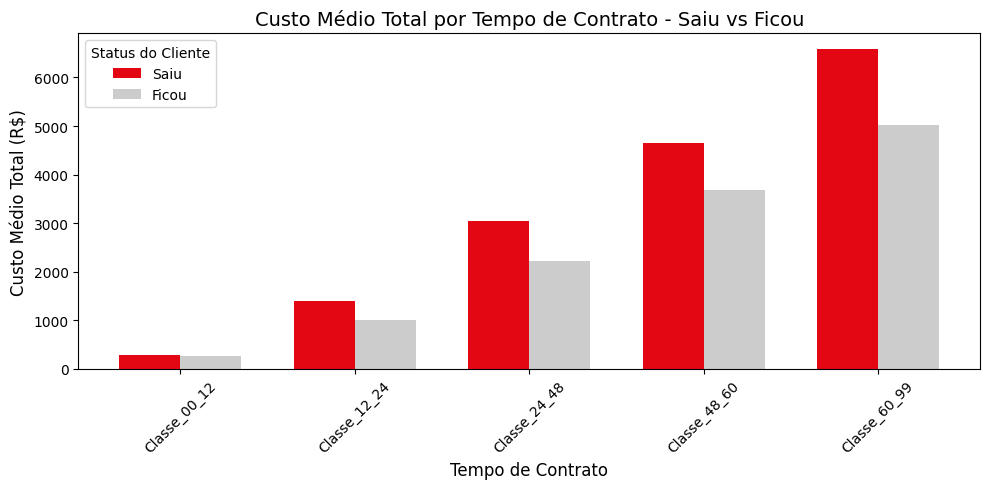

In [1631]:
merged_data = pd.merge(
    freq_tab_01, freq_tab_02, on="Tempo Contrato", how="outer", suffixes=("_Saiu", "_Ficou")
).fillna(0)  

merged_data = merged_data.sort_values(by="Tempo Contrato")  # Ordenar por Tempo Contrato
x_labels = merged_data["Tempo Contrato"]
custo_total_saiu = merged_data["Custo Médio Total_Saiu"]
custo_total_ficou = merged_data["Custo Médio Total_Ficou"]

plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(x_labels))

plt.bar(x, custo_total_saiu, bar_width, label="Saiu", color="#E30613")  # Vermelho
plt.bar([i + bar_width for i in x], custo_total_ficou, bar_width, label="Ficou", color="#CCCCCC")  # Cinza claro

plt.xlabel("Tempo de Contrato", fontsize=12)
plt.ylabel("Custo Médio Total (R$)", fontsize=12)
plt.title("Custo Médio Total por Tempo de Contrato - Saiu vs Ficou", fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
plt.legend(title="Status do Cliente")
plt.tight_layout()

plt.show()

O custo medio total por tempo de relacionamento é mais alto para pessoas que sairam também, mas aumentando gradativamente por faixa de tempo de contrato. 

## Feature Engineering

Separando as colunas (variáveis) em seus respectivos tipos:
* ID
* Resposta
* Categórico: duas classes (binário)
* Categórico: múltiplas classes
* Numérico
Começamos pelas variáveis resposta e ID.

In [1632]:
var_id = ['ID']
var_resposta = ['Churn']

In [1633]:
var_cat   = dados.nunique()[dados.nunique() < 10].keys().tolist()
var_cat   = [var for var in var_cat if var not in var_resposta + var_id]

In [1634]:
var_num   = [var for var in dados.columns if var not in var_cat + var_resposta + var_id]

In [1635]:
var_bin   = dados.nunique()[dados.nunique() == 2].keys().tolist()
var_bin   = [var for var in var_bin if var not in var_id + var_resposta]

In [1636]:
var_multi = [var for var in var_cat if var not in var_bin]

Transformando as variaveis.

#### Variáveis Binárias

In [1637]:
encoders = list()

for var in var_bin:
    le = LabelEncoder()
    
    le_fitted = le.fit(dados[var])
    
    dados[var] = le_fitted.transform(dados[var])
    
    encoders.append((var, le_fitted))

Fazendo a mesma coisa com a variável resposta.

In [1638]:
dados[var_resposta] = dados[var_resposta] * 1

In [1639]:
dados.head(3)

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,Churn,ClasseTempoContrato
0,0495-RVCBF,0,0,0,0,1,1,False,Fibra,0,0,0,0,0,1,Mensal,1,Conta Eletronica,79.7,79.70,1,Classe_00_12
1,5215-LNLDJ,0,0,1,1,7,0,Sem Telefone,DSL,0,0,0,0,0,0,Mensal,1,Conta Eletronica,24.7,149.05,0,Classe_00_12
2,7956-XQWGU,1,0,0,0,27,1,False,Sem Internet,0,0,0,0,0,0,Mensal,1,Credito Automatico,19.4,460.25,0,Classe_24_48


#### Variáveis Categóricas Multi-Classe

In [1640]:
# funcoes de modelagem
def predicoes_binarias(df_input, cols_keep, cols_model, path_model='../Modelos/xgb_otimizado.pkl'):
    # Carrega o modelo treinado
    model = joblib.load(path_model)
    
    # Inicializa o df com as predições
    df = pd.DataFrame()
    for col in cols_keep:
        df[col] = df_input[col].values
    
    # norm
    input_model = normalizing(df_input, cols_model)
    
    prob_class = model.predict_proba(input_model)[:, 1]  # Probabilidade da classe positiva
    
    df['PROB_CLASSE_POSITIVA'] = prob_class
    df['CLASSE_PREDITA'] = (prob_class > 0.5).astype(int)  # Classifica como 1 se a probabilidade da classe positiva (que eu quero prever) for maior que 0.5, senão como 0
    # Adicione as colunas de cols_model ao DataFrame de predição
    for col in cols_model:
        df[col] = df_input[col].values
        
        
    return df

def get_cols(df, target='cancellation', cols2exc=[]):
    '''
    Separa as features para normalização, enconding e target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def normalizing(df, target='cancellation', cols2exc=[]):
    '''
    Aplica o enconding e normalização aos dados
    '''   
    # separate cols
    cols2enc, cols2norm = get_cols(df, target, cols2exc)
    #print(cols2enc, cols2norm)
    df_norm = pd.DataFrame()
    
    # encoding 
    enc_mapping = list()
    encoder = LabelEncoder()
    for col in cols2enc:
        encoded = encoder.fit_transform(df[col])#.astype(str))
        df_norm[col] = encoded
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        enc_mapping.append([col, mapping])
        
    # normalizing
    scaler = MinMaxScaler()
    for col in cols2norm:
        encoded = scaler.fit_transform(df[col].astype(float).values.reshape(-1, 1))
        df_norm[col] = encoded
        
    return df_norm, enc_mapping

def get_model(X, y, nsplit=3, min_features=10, njobs=-1):
    '''
    Retorna o RFE + CV 
    '''
    rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y)
    return RFECV(estimator=rfc, step=nsplit, min_features_to_select=min_features, cv=cv, n_jobs=njobs)

def get_features_info(rfecv, X, df, style=None):
    '''
    Retorna a análise das features selecionadas pelo RFECV + dataframe com essas features
    '''
    print('Número ótimo de variáveis selecionadas pelo RFE: {}'.format(rfecv.n_features_))
    
    if not style:
        style = {'font-family': 'manrope', 
                 'color-header': 'white',
                 'background-header': '#000000',
                 'header-fsize': '16px',
                 'background-even': '#7a7423',
                 'background-odd': '#a7e82b',
                 'rows-fsize' : '14px',
                 'figsize': (12,12),
                 'cmap': 'Greens',
                 'color': '#c04cfd'}
        
    # Visualizando as importancia das variáveis selecionadas
    X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    dset = pd.DataFrame()
    dset['attr'] = X2.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    dset = dset.sort_values(by='importance', ascending=True)

    fig, axs = plt.subplots(2,1, figsize=style['figsize'], gridspec_kw={'height_ratios': [1, 3]})
    fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')
    axs[0].plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], 
                color=style['color'], linewidth=3)
    axs[0].set_xlabel('Number of features selected', fontsize=14, labelpad=20)
    axs[0].set_ylabel('% Correct Classification', fontsize=14, labelpad=20)
    axs[1].barh(y=dset['attr'], width=dset['importance'], color=style['color'])
    axs[1].set_xlabel('Importancia', fontsize=14, labelpad=20)
    
    # Tabela com as variáveis e seu percentual de importancia
    df_import = pd.DataFrame(zip(dset.attr, [f'{x*100:.2f}%' for x in dset.importance.sort_values(ascending=True)]), columns=['Variável', 'Importancia'])
    print(df_import)

    # Variáveis selecionadas pelo RFE/RF
    cols_rfe = dset.attr
    # Dataframe com as features selecionadas 
    return df_import, df[cols_rfe.tolist()]

def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):

    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models'
    outname = nome para o output - nome do modelo 

    output:
    retorna = arquivo salvo ou modelo carregado

    '''

    import os
    import joblib
    import pickle

    outname = os.path.join(path2save, outname)
    outfile = f"{outname}.{ftype}"

    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')  

        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))

    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')  

        else:
            return joblib.load(f'{outfile}')

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def model_metrics(X_test, y_test, model,  average_type='macro'):
    y = y_test
    y_pred = xgb.predict(X_test)

    model_metrics_dict = {'Acurácia': accuracy_score(y, y_pred),
                          'Precisão': precision_score(y, y_pred, average=average_type),
                          'Recall': recall_score(y, y_pred, average=average_type),
                              'F1-Score': f1_score(y, y_pred, average=average_type)}


    return model_metrics_dict

In [1641]:
# salvar os dados originais em um df
dados_originais =  dados.copy()

In [1642]:
dados_originais.sample(3)

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,Churn,ClasseTempoContrato
4270,4418-LZMSV,1,0,1,1,13,1,False,DSL,0,1,1,1,0,0,Mensal,0,Debito Automatico,61.80,750.10,0,Classe_12_24
2232,9537-JALFH,1,0,1,1,69,1,False,Sem Internet,0,0,0,0,0,0,Bienal,0,Debito Automatico,19.90,1356.70,0,Classe_60_99
3147,2955-BJZHG,1,0,1,1,17,1,False,Fibra,0,0,0,0,1,0,Mensal,0,Conta Eletronica,80.85,1400.85,1,Classe_12_24


In [1643]:
# Transformando variáveis categóricas em um formato numérico que pode ser interpretado por modelos.
dados = pd.get_dummies(data = dados, columns = var_multi)

In [1644]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                5274 non-null   object 
 1   Sexo                              5274 non-null   int64  
 2   Idoso                             5274 non-null   int64  
 3   Casado                            5274 non-null   int64  
 4   Dependentes                       5274 non-null   int64  
 5   TempoContrato                     5274 non-null   int64  
 6   Telefone                          5274 non-null   int64  
 7   AntiVirus                         5274 non-null   int64  
 8   Backup                            5274 non-null   int64  
 9   Seguro                            5274 non-null   int64  
 10  Suporte                           5274 non-null   int64  
 11  TV                                5274 non-null   int64  
 12  Filmes

#### Variáveis Numéricas

In [1645]:
# Passando o scaler para normalizar a distribuição dos dados.
std = MinMaxScaler()

scaled = std.fit_transform(dados[var_num])
scaled = pd.DataFrame(scaled, columns = var_num)

In [1646]:
# Inserindo variáveis NOISE e separando features do target (tecnica RANDOM BAR)

cols2exc=["ID"]
target = ['Churn']

# Insere noise
dados['NOISE1'] = np.random.normal(0, 1, dados.shape[0])
dados['NOISE2'] = np.random.rand(dados.shape[0])

X = dados.drop(cols2exc+target, axis=1) 
y = dados[target[0]].values 

CPU times: user 2.66 s, sys: 152 ms, total: 2.82 s
Wall time: 9.26 s
Número ótimo de variáveis selecionadas: 26
Número ótimo de variáveis selecionadas pelo RFE: 26
                            Variável Importancia
0                       Internet_DSL       1.02%
1                              Idoso       1.17%
2                             Seguro       1.25%
3   ClasseTempoContrato_Classe_60_99       1.29%
4                 TipoContrato_Anual       1.34%
5              LinhasMultiplas_False       1.35%
6                             Backup       1.37%
7                                 TV       1.39%
8                        Dependentes       1.44%
9                             Filmes       1.44%
10                            Casado       1.53%
11                         AntiVirus       1.60%
12             Internet_Sem Internet       1.64%
13                           Suporte       1.77%
14                              Sexo       1.85%
15                      ContaDigital       1.87%
16 

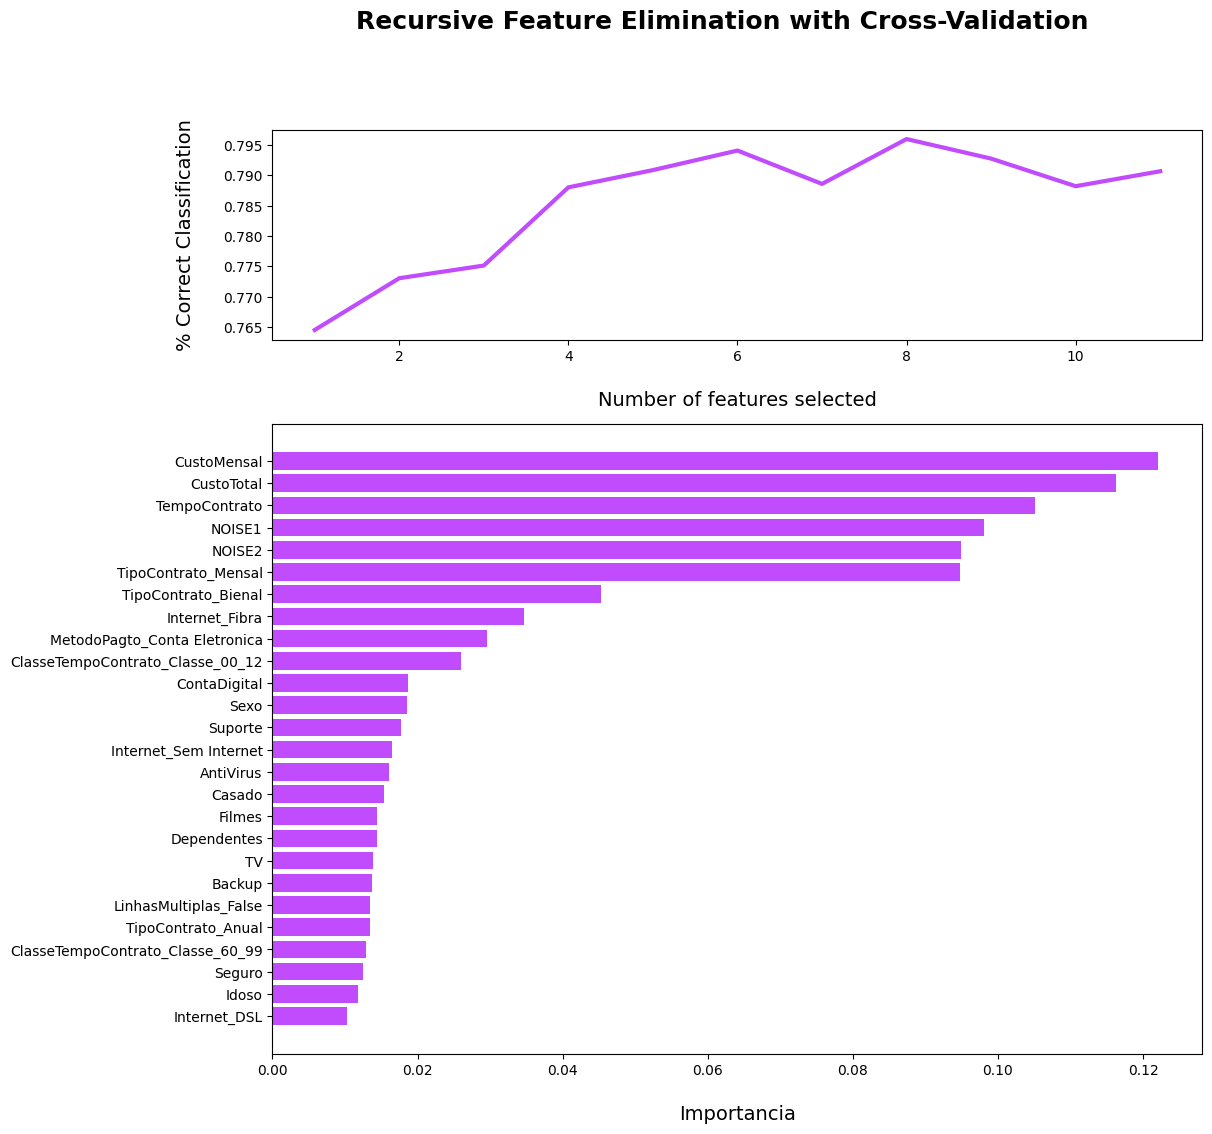

In [1647]:
# Instanciando e ajustar o modelo
rfecv = get_model(X, y, nsplit=3, min_features=5)
%time rfecv.fit(X, y)

print(f"Número ótimo de variáveis selecionadas: {rfecv.n_features_}")

importancia_features, df_selecionado = get_features_info(rfecv, X, dados)

RandomBar é uma tecnica que adiciona noise no dataset para facilitar a escolha de variaveis para modelos de classificacao. Como utilizei o RFE para definir as variaveis mais influentes, o que fica após o NOISE adicionado na base é descartado por nao apresentar significancia. Como pode-se ver, 3 variaveis sao as mais impactantes.

In [1648]:
# Catboost classifier - traina  um modelo de classificação utilizando o 
# CatBoost e seleciona as features mais relevantes para o problema com
#  base nos valores SHAP (SHapley Additive exPlanations) 
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

# Selecionando as melhores features
selected_features = model.select_features(
    X=X,
    y=y,
    features_for_select=X.columns,
    num_features_to_select=15, 
    algorithm="RecursiveByShapValues",
    steps=5,
    train_final_model=False,
    verbose=False,
)

Step #1 out of 5
Feature #32 eliminated
Feature #16 eliminated
Feature #5 eliminated
Feature #18 eliminated
Feature #21 eliminated
Step #2 out of 5
Feature #17 eliminated
Feature #31 eliminated
Feature #27 eliminated
Feature #26 eliminated
Feature #29 eliminated
Step #3 out of 5
Feature #25 eliminated
Feature #8 eliminated
Feature #30 eliminated
Feature #2 eliminated
Step #4 out of 5
Feature #28 eliminated
Feature #10 eliminated
Feature #7 eliminated
Step #5 out of 5
Feature #1 eliminated
Feature #11 eliminated
Feature #3 eliminated


In [1649]:
index = list(selected_features.get('selected_features'))
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

index_att = list(np.sort((index)))
index_att

[0, 4, 6, 9, 12, 13, 14, 15, 19, 20, 22, 23, 24, 33, 34]

In [1650]:
# fitando o modelo com as variaveis selecionadas pelo CBC
model.fit(X.iloc[:, index_att],y, verbose = False)

In [1651]:
feature_importance = model.get_feature_importance(data=Pool(X.iloc[:, index_att], label=y), type="LossFunctionChange")
feature_importance = feature_importance.reshape(-1,1)
feature_importance = feature_importance[feature_importance > 0]* 100 
feature_importance

array([0.42816292, 4.98606278, 0.5502974 , 0.55514182, 0.51238466,
       4.89883993, 3.33079401, 0.41399191, 0.60261776, 0.49296915,
       0.32154741, 1.24317122, 0.56864749, 3.19570809, 3.24413681])

In [1652]:
feature_importance_df = pd.DataFrame({
    'Feature': X.iloc[:,index_att].columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'NOISE1']
feature_importance_df

,Feature,Importance
10,TipoContrato_Bienal,0.321547
7,LinhasMultiplas_False,0.413992
0,Sexo,0.428163
9,Internet_Sem Internet,0.492969
4,ContaDigital,0.512385
2,AntiVirus,0.550297
3,Suporte,0.555142
12,MetodoPagto_Conta Eletronica,0.568647
8,Internet_Fibra,0.602618
11,TipoContrato_Mensal,1.243171


Como pode-se visualizar pela tabela, os dados, mesmo utilizando outro metodo para selecionar as features mais importantes, o resultado foi o mesmo.

In [1653]:
feature_clean = feature_importance_df['Feature']
feature_clean_list = feature_clean.tolist()

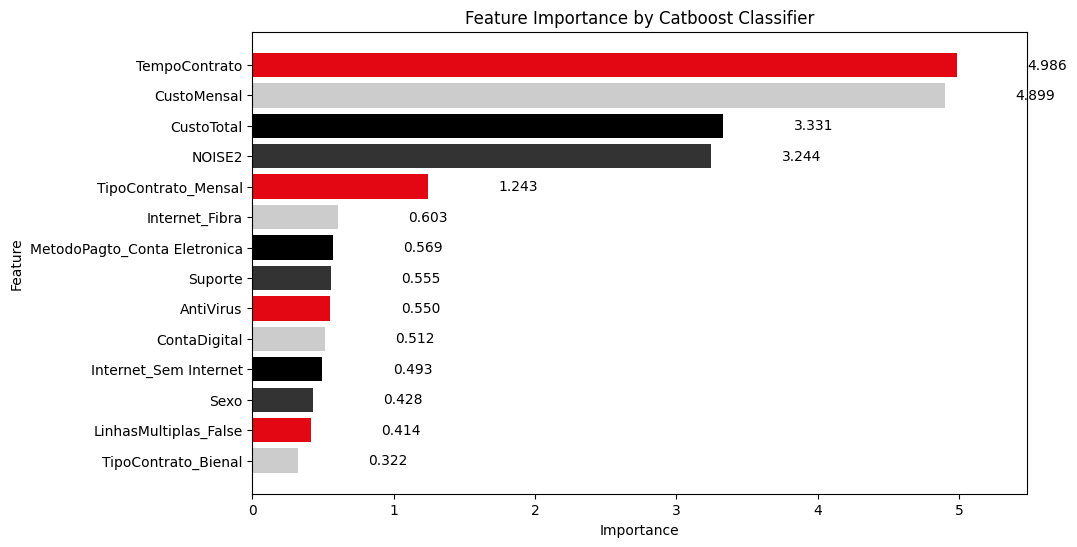

In [1654]:
# Plotando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=furukawa_colors)

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Catboost Classifier')
plt.xlim(0, max(feature_importance_df['Importance']) * 1.1)  # Definindo limites do eixo x

plt.show()

Pode-se ver que ambas as tecnicas de Feature Selection deram resultados iguais para o modelo: Custo Mensal, TempoContrato e CustoTotal no topo. Com isso o modelo segue simples com essas 3 variáveis.

In [1655]:
# Função que Salva ou carrega um modelo (ftype = tipo do arquivo, pkl ou joblib)
def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):
    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models' 
    outname = nome para o output - nome do modelo

    output:
    retorna = arquivo salvo ou modelo carregado
    '''
    import os
    import joblib
    import pickle
    
    outname = os.path.join(path2save, outname) 
    outfile = f"{outname}.{ftype}" 
    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')   
        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))
    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')   
        else:
            return joblib.load(f'{outfile}')
        
# Parametros
def grid_search(X, y, model=LogisticRegression(), nsplit=3, param_grid={}, average_type='macro', njobs=-1):
    '''
    Executa o grid search
    '''
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y) 
    score = make_scorer(f1_score, average=average_type, greater_is_better=True)
    clf = GridSearchCV(model, param_grid, scoring=score, cv=cv, n_jobs=njobs)
    clf.fit(X, y)
    print('F1 score: ', clf.best_score_)
    print('Best parameters: ', clf.best_params_)
    return clf.cv_results_['mean_test_score']

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def eval_model(model, X, y, average_type='macro', labels=None, target_names=None):
    '''
    Retorna as metricas básicas de acordo com a predição
    '''
    y_pred = model.predict(X)
    #auc_scores = roc_auc_score(y, model.predict_proba(X))  #multi_class='ovr', average=None)
    class_order = [int(model.classes_[i]) for i in labels]
    #score_order = [auc_scores[n] for n in class_order]
    #aucs = [f'class {x}: {val:.2%}' for x, val in zip(target_names,score_order)]
    print('Report: \n', classification_report(y, y_pred, labels=labels, target_names=target_names))
    print('Accuracy: %.3f' % (accuracy_score(y, y_pred)))
    print('Precision: %.3f' % (precision_score(y, y_pred, average=average_type)))
    print('Recall: %.3f' % (recall_score(y, y_pred, average=average_type)))
    print('F1 score: %.3f' % (f1_score(y, y_pred, average=average_type)))
    #print('AUC scores for each class using One-vs-rest: \n', aucs)

def plot_conf_matrix(model, X_train, X_test, y_test, y_train,
                     eval_mode='ovr',
                     average_type='macro',
                     cmap_='Greens',
                     labels_order=None,
                     target_names=None,
                     tick_marks=None):
    
    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    roc_test = roc_auc_score(y_test, y_pred)
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')

    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)

def eval_model_all(model, X, y, X_train, X_test, y_train, y_test, eval_mode='ovr', average_type='macro', cmap_='Greens', labels_order=None, target_names=None, tick_marks=None):
    '''
    Retorna todas as principais metricas levando em consideração dos os dados
    '''

    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test) 
    y_allp = model.predict_proba(X)

    roc_train = roc_auc_score(y_train, y_pred_trainp) # multi_class=eval_mode)  
    roc_test = roc_auc_score(y_test, y_predp)# multi_class=eval_mode)
    roc_all = roc_auc_score(y, y_allp) #multi_class=eval_mode)
    print(f'ROC_AUC score train: {roc_train*100:.2f}%')
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')
    print(f'ROC_AUC score all: {roc_all*100:.2f}% \n')
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pall = model.predict(X)
    
    print(f'Accuracy for train: {accuracy_score(y_train, y_pred_train)*100:.2f}%')
    print(f'Accuracy for test: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Accuracy for all: {accuracy_score(y,y_pall)*100:.2f}% \n')
    
    sen_train = sensitivity_score(y_train, y_pred_train, average=average_type)
    sen_test = sensitivity_score(y_test, y_pred, average=average_type)
    sen_all = sensitivity_score(y, y_pall, average=average_type)
    spe_train = specificity_score(y_train, y_pred_train, average=average_type)
    spe_test = specificity_score(y_test, y_pred, average=average_type)
    spe_all = specificity_score(y, y_pall, average=average_type)
    print(f'Sensitivity for train: {sen_train*100:.2f}%, Specificity for train: {spe_train*100:.2f}')
    print(f'Sensitivity for test: {sen_test*100:.2f}%, Specificity for test: {spe_test*100:.2f}')
    print(f'Sensitivity for all: {sen_all*100:.2f}%, Specificity for all: {spe_all*100:.2f} \n')
                
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)

## Resumo das Variáveis

Como todas as variáveis são números, podemos descrever nossos dados.

In [1656]:
np.around(X.describe().T,3)

,count,mean,std,min,25%,50%,75%,max
Sexo,5274.0,0.500,0.500,0.000,0.000,1.000,1.000,1.000
Idoso,5274.0,0.159,0.366,0.000,0.000,0.000,0.000,1.000
Casado,5274.0,0.485,0.500,0.000,0.000,0.000,1.000,1.000
Dependentes,5274.0,0.301,0.459,0.000,0.000,0.000,1.000,1.000
TempoContrato,5274.0,32.606,24.576,1.000,9.000,29.000,56.000,72.000
Telefone,5274.0,0.901,0.299,0.000,1.000,1.000,1.000,1.000
AntiVirus,5274.0,0.283,0.451,0.000,0.000,0.000,1.000,1.000
Backup,5274.0,0.342,0.474,0.000,0.000,0.000,1.000,1.000
Seguro,5274.0,0.342,0.475,0.000,0.000,0.000,1.000,1.000
Suporte,5274.0,0.288,0.453,0.000,0.000,0.000,1.000,1.000


Demográficos e Serviços:</br>

Sexo, Idoso, Casado, Dependentes: Binários, balanceados, exceto Idoso (16% idosos).</br>
Telefone, AntiVirus, Backup, Seguro, Suporte: Majoritariamente usados parcialmente, Telefone é predominante (90%). </br>

Financeiros:</br>

CustoMensal: Média de $64.65 com desvio padrão de $30.03, indicando variação significativa.</br>
CustoTotal: Média de $2,281 com alta dispersão (std: $2,253), variando de $18.8 a $8,672.</br>
Contratos:</br>

TempoContrato: Média de 33 meses, ampla variação (std: 24.6).
ContaDigital: Usada em 59% dos casos.</br>

# Construindo um Modelo

In [1657]:
feature_importance_df = feature_importance_df[-3:]

variaveis_selecionadas = list(feature_importance_df.Feature) 
variaveis_selecionadas

['CustoTotal', 'CustoMensal', 'TempoContrato']

In [1658]:
# ajustando o df do modelo
df_rfe = dados[variaveis_selecionadas]
df_rfe['Churn'] = dados['Churn']
df_rfe

,CustoTotal,CustoMensal,TempoContrato,Churn
0,79.70,79.70,1,1
1,149.05,24.70,7,0
2,460.25,19.40,27,0
3,5744.35,103.20,56,0
4,1761.05,89.65,19,1
...,...,...,...,...
5269,125.50,25.05,5,0
5270,494.90,19.65,26,0
5271,408.25,49.40,8,0
5272,663.55,76.85,9,0


In [1659]:
#separando a base de validação 

df_validation = shap.sample(df_rfe, nsamples= int(df_rfe.shape[0]* 0.20))
X_val = df_validation.drop('Churn', axis = 1)
y_val = df_validation['Churn']

#retirando os dados da validação da base principal

df_rfe = df_rfe.drop(df_validation.index)
df_rfe

,CustoTotal,CustoMensal,TempoContrato,Churn
0,79.70,79.70,1,1
1,149.05,24.70,7,0
2,460.25,19.40,27,0
3,5744.35,103.20,56,0
5,897.75,102.60,9,0
...,...,...,...,...
5269,125.50,25.05,5,0
5270,494.90,19.65,26,0
5271,408.25,49.40,8,0
5272,663.55,76.85,9,0


<Axes: title={'center': 'Test sample'}, ylabel='count'>

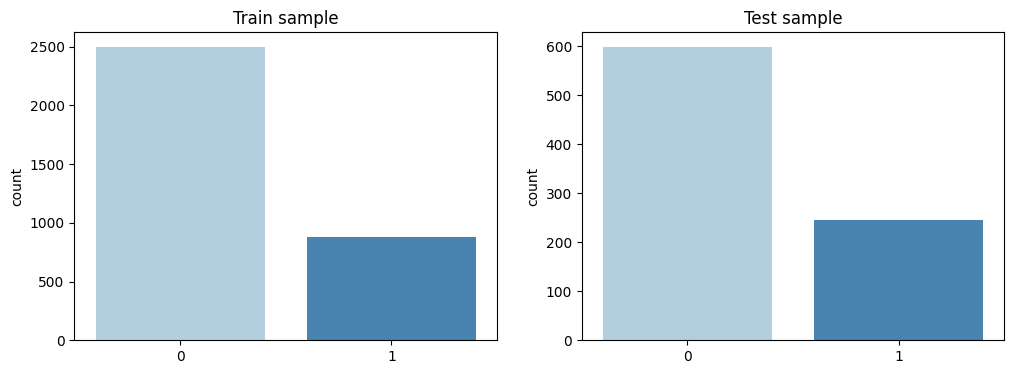

In [1660]:
# Separa as features
cols2exc = []
target = ['Churn']

X = df_rfe.drop(cols2exc + target, axis=1) # features
y = df_rfe[target[0]].values # target

# Divide os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# check da distribuição dos targets
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text("Train sample")
sns.countplot(x=y_train, ax=axs[0], palette='Blues')
axs[1].title.set_text("Test sample")
sns.countplot(x=y_test, ax=axs[1], palette='Blues')

In [1661]:
class_validation = pd.DataFrame(pd.DataFrame(y_train).value_counts(normalize = True).mul(100).round(2))
class_validation #proporcao das classes 

,proportion
0,
0,73.99
1,26.01


In [1662]:
# balanceando as classes para testar resultados
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_train_bl, y_train_bl = rus.fit_resample(X_train, y_train)

<Axes: title={'center': 'Test sample'}, ylabel='count'>

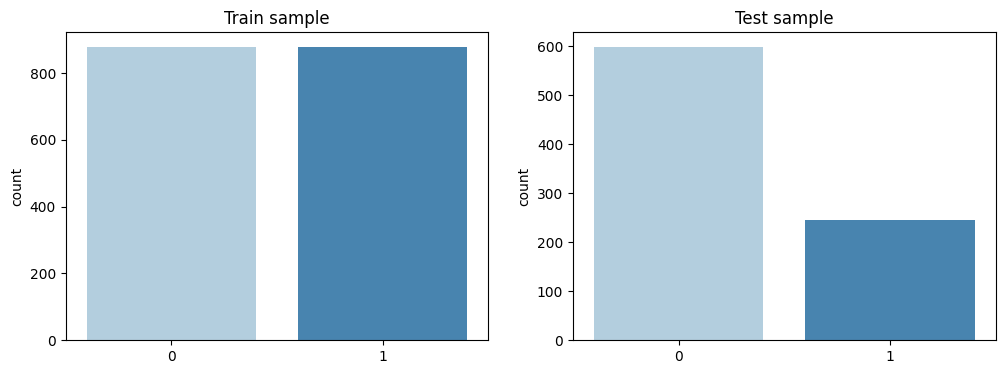

In [1663]:
# check da distribuição dos targets
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text("Train sample")
sns.countplot(x=y_train_bl, ax=axs[0], palette='Blues')
axs[1].title.set_text("Test sample")
sns.countplot(x=y_test, ax=axs[1], palette='Blues')

In [1664]:
class_validation = pd.DataFrame(pd.DataFrame(y_train_bl).value_counts(normalize = True).mul(100).round(2))
class_validation 

,proportion
0,
0,50.0
1,50.0


In [1665]:
# otimizando com Optuna
def objective(trial):
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    clf = XGBClassifier(random_state=42, n_jobs=-1, **param_dist)

    score = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1).mean()

    return -score  

study = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score
# OTIMIZANDO parametro
study.optimize(objective, n_trials=50)  

best_params = study.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2024-12-09 09:53:29,257] A new study created in memory with name: no-name-ffdbcfa7-7921-4778-8635-bbd19d4ccfd8
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/wsl/churn_furukawa/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "criterion", "max_features", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-09 09:53:30,088] Trial 0 finished with value

Melhores hiperparâmetros: {'max_features': 'log2', 'max_depth': 29, 'min_samples_split': 41, 'class_weight': 'balanced', 'criterion': 'log_loss'}


In [1666]:
rfc_params = study.best_params
rfc_params['n_jobs'] = -1
rfc_params['random_state'] = 13 

rfc = fit_model(X_train, y_train, model=XGBClassifier(**rfc_params))

y_pred = rfc.predict(X_test)

eval_model(rfc, X_test, y_test, labels=[0,1], target_names=['No Churn','Churn'])

Report: 
               precision    recall  f1-score   support

    No Churn       0.80      0.84      0.82       599
       Churn       0.56      0.49      0.52       245

    accuracy                           0.74       844
   macro avg       0.68      0.67      0.67       844
weighted avg       0.73      0.74      0.74       844

Accuracy: 0.741
Precision: 0.681
Recall: 0.668
F1 score: 0.673


Para tarzer melhorias para os modelos que apresenta um score de precision e recall relativamente baixo de primeira, vou testar outros algoritmos de classificaçao:


In [1667]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def test_model(model, X_train, X_test, y_train, y_test, model_name):

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"\nMétricas para {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

algorithms = {
    "Random Forest": RandomForestClassifier(**best_params, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(**best_params, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

for model_name, model in algorithms.items():
    test_model(model, X_train, X_test, y_train, y_test, model_name)



Métricas para Random Forest:
              precision    recall  f1-score   support

    No Churn       0.88      0.76      0.82       613
       Churn       0.53      0.72      0.61       231

    accuracy                           0.75       844
   macro avg       0.71      0.74      0.71       844
weighted avg       0.78      0.75      0.76       844

Matriz de Confusão:
[[466 147]
 [ 64 167]]

Métricas para XGBoost:
              precision    recall  f1-score   support

    No Churn       0.81      0.85      0.83       613
       Churn       0.54      0.47      0.50       231

    accuracy                           0.75       844
   macro avg       0.68      0.66      0.67       844
weighted avg       0.74      0.75      0.74       844

Matriz de Confusão:
[[521  92]
 [122 109]]

Métricas para Logistic Regression:
              precision    recall  f1-score   support

    No Churn       0.81      0.92      0.86       613
       Churn       0.67      0.42      0.52       231

    ac

Random Forest:</br>

Desempenho: Boa precisão para No Churn (88%), mas moderada para Churn (53%).
Recall: Melhor para Churn (72%) que No Churn (76%), indicando maior capacidade de identificar clientes que provavelmente churnam.
Acurácia Geral: 75%
F1-Score: Balanceado entre classes (0.81 para No Churn, 0.61 para Churn).
Confusão: 147 falsos positivos (clientes erroneamente previstos como churn).

XGBoost: </br>
Desempenho: Mais equilibrado em classes, mas menor precisão para Churn (55%).
Recall: Melhor para No Churn (85%) do que Churn (47%).
Acurácia Geral: 75%.
F1-Score: Similar entre classes (0.83 para No Churn, 0.51 para Churn).
Confusão: 90 falsos positivos e 122 falsos negativos.

Logistic Regression:</br>
Desempenho: Alta precisão para No Churn (81%) e Churn (67%).
Recall: Muito alto para No Churn (92%), mas baixo para Churn (42%), indicando baixa identificação de clientes churn.
Acurácia Geral: 79%, melhor entre os três modelos.
F1-Score: Melhor para No Churn (0.86), menor para Churn (0.52).
Confusão: 47 falsos positivos e 134 falsos negativos.</br>


Random Forest é mais equilibrado entre precisão e recall, adequado para campanhas.</br>
XGBoost é consistente em balancear classes, mas com menor recall para churn.</br>
Logistic Regression apresenta alta acurácia geral, mas baixa detecção de churn (muito conservador).</br>

In [1668]:
# ausje to melhor modelo calibranco as probabilidades usando o metodo de regressao isotomico
rfc = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(estimator=rfc, method='isotonic', cv='prefit')
calibrated_model.fit(X_train, y_train)

y_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

y_pred_calibrated = (y_proba_calibrated > 0.5).astype(int)

print("Métricas do Modelo Calibrado:")
print(classification_report(y_test, y_pred_calibrated, target_names=['No Churn', 'Churn']))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_calibrated))

Métricas do Modelo Calibrado:
              precision    recall  f1-score   support

    No Churn       0.83      0.89      0.86       613
       Churn       0.63      0.51      0.56       231

    accuracy                           0.78       844
   macro avg       0.73      0.70      0.71       844
weighted avg       0.77      0.78      0.78       844

Matriz de Confusão:
[[544  69]
 [114 117]]


In [1669]:
features_usadas = rfc.feature_names_in_
print("Variáveis usadas pelo modelo:")
print(features_usadas)

Variáveis usadas pelo modelo:
['CustoTotal' 'CustoMensal' 'TempoContrato']


In [1670]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.calibration import CalibratedClassifierCV

rfc = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)

calibrated_model = CalibratedClassifierCV(estimator=rfc, method='isotonic', cv='prefit')
calibrated_model.fit(X_train, y_train)

missing_features = set(rfc.feature_names_in_) - set(X_test.columns)
if missing_features:
    print(f"Adicionando as colunas ausentes: {missing_features}")
    for col in missing_features:
        X_test[col] = 0  

X_test_adjusted = X_test[rfc.feature_names_in_]  

explainer = ClassifierExplainer(
    calibrated_model,
    X_test_adjusted,
    y_test,
    labels=["No Churn", "Churn"]
)

dashboard = ExplainerDashboard(
    explainer,
    title="Churn Prediction Dashboard"
)

dashboard.run()

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/844 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.31.165.130:8050


Random Forest
Métricas de Desempenho:
No Churn (Classe 0):

Precisão: 0.87 → Alta precisão, indicando que quando o modelo prevê "No Churn", geralmente está correto.
Recall: 0.81 → 81% dos clientes que realmente não churnaram foram corretamente classificados.
F1-Score: 0.84 → Boa combinação de precisão e recall.
Churn (Classe 1):

Precisão: 0.57 → Quando o modelo prevê "Churn", está correto em 57% dos casos.
Recall: 0.69 → O modelo identifica 69% dos clientes que realmente churnaram.
F1-Score: 0.62 → Moderada, mostrando algum desequilíbrio na capacidade do modelo de lidar com esta classe.
Geral:

Acurácia: 77% → O modelo classifica corretamente 77% dos casos.
Média Macro:
Recall (0.75) sugere que o modelo é melhor em capturar exemplos reais de ambas as classes.
Média Ponderada: Ponderada pelo suporte, as métricas são sólidas para ambas as classes.

Erros Comuns:
119 falsos positivos (clientes que o modelo previu como churn, mas não saíram). 
72 falsos negativos (clientes que churnaram, mas o modelo não identificou).

No nosso caso, é mais importante errar trabalhando na retencao de um cliente que ja ficaria por erro do modelo (considerando o numero mais baixo dos falsos negativos). Os falsos negativos sao mais caros para nos.

XGBoost
Métricas de Desempenho:
No Churn (Classe 0):

Precisão: 0.80 → Um pouco menor do que o Random Forest, mas ainda boa.
Recall: 0.87 → Maior do que o Random Forest, indicando melhor detecção de "No Churn".
F1-Score: 0.84 → Semelhante ao Random Forest para esta classe.
Churn (Classe 1):

Precisão: 0.56 → Ligeiramente pior do que Random Forest.
Recall: 0.44 → Inferior ao Random Forest, capturando apenas 44% dos clientes que churnaram.
F1-Score: 0.49 → Significativamente menor, mostrando dificuldade em lidar com esta classe.
Geral:

Acurácia: 75% → Menor do que o Random Forest.
Média Macro:
Recall (0.65) → Indica que o modelo tem dificuldade em capturar exemplos reais da classe churn (Classe 1).
Média Ponderada: Menos equilibrada, com melhor desempenho na classe maioritária.
rros Comuns:
134 falsos negativos (clientes que churnaram, mas o modelo não identificou).
46 falsos positivos (menor taxa de erro do que Random Forest nesta categoria).

Métrica	Random Forest	XGBoost
Acurácia	77%	75%
Recall (Classe 1)	0.69	0.44
F1-Score (Classe 1)	0.62	0.49
Falsos Negativos	72	134
Falsos Positivos	119	46

In [1671]:
vars_entrada = ['CustoTotal', 'TempoContrato', 'CustoMensal']
dados_previsao = dados[vars_entrada] 

# Realizando previsoes


In [1672]:
dados_originais_previsao = pd.read_csv(r'fel_churn_previsao_nb_01.csv')

In [1673]:
dados_previsao = dados_originais_previsao.copy()

In [1674]:
dados_originais_previsao.head(3)

,ID,Sexo,Idoso,Casado,Dependentes,TempoContrato,Telefone,LinhasMultiplas,Internet,AntiVirus,Backup,Seguro,Suporte,TV,Filmes,TipoContrato,ContaDigital,MetodoPagto,CustoMensal,CustoTotal,ClasseTempoContrato
0,0774-RMNUW,Feminino,False,True,True,71,False,Sem Telefone,DSL,True,True,False,True,True,True,Bienal,False,Debito Automatico,59.70,4122.65,Classe_60_99
1,8910-LEDAG,Masculino,True,True,False,34,True,False,Fibra,False,False,False,False,False,False,Mensal,False,Credito Automatico,71.55,2427.35,Classe_24_48
2,4412-YLTKF,Feminino,True,False,False,27,True,True,Fibra,False,False,True,False,False,False,Mensal,True,Conta Eletronica,78.05,2135.50,Classe_24_48


In [1675]:
vars_entrada = calibrated_model.feature_names_in_
dados_previsao_adjusted = dados_originais_previsao[vars_entrada]

dados_originais_previsao['Probabilidade_Churn'] = calibrated_model.predict_proba(dados_previsao_adjusted)[:, 1]

dados_priorizados = dados_originais_previsao.sort_values(by='Probabilidade_Churn', ascending=False)

clientes_priorizados = dados_priorizados[['ID', 'Probabilidade_Churn']]

In [1676]:
print(clientes_priorizados.sample(10))

              ID  Probabilidade_Churn
1395  7693-QPEFS             0.054054
1579  9360-OMDZZ             0.539683
1067  9644-UMGQA             0.432749
986   1098-TDVUQ             0.380165
854   2843-CQMEG             0.108871
510   8053-WWDRO             0.000000
256   8092-NLTGF             0.000000
531   0336-PIKEI             0.000000
693   0100-DUVFC             0.004854
1457  3696-DFHHB             0.000000


In [1677]:
clientes_priorizados.groupby('Probabilidade_Churn').describe().T

Probabilidade_Churn    0.000000    0.004854    0.007210    0.018519  \
ID count                    451          93           1          67   
   unique                   451          93           1          67   
   top               8957-THMOA  3639-XJHKQ  5726-CVNYA  5815-HGGHV   
   freq                       1           1           1           1   

Probabilidade_Churn    0.054054    0.076854    0.078740    0.101842  \
ID count                     60           1          54           1   
   unique                    60           1          54           1   
   top               6917-YACBP  0623-EJQEG  2817-NTQDO  2826-UWHIS   
   freq                       1           1           1           1   

Probabilidade_Churn    0.108871    0.216138    0.216216    0.276596  \
ID count                    147         176          17          18   
   unique                   147         176          17          18   
   top               0774-IFUVM  5566-SOEZD  8375-KVTHK  2041-JIJCI   
   freq                       1           1           1           1   

Probabilidade_Churn    0.294118    0.300000    0.301439    0.333333  \
ID count                     12          10           1           1   
   unique                    12          10           1           1   
   top               7318-EIVKO  6728-WYQBC  2037-XJFUP  7878-JGDKK   
   freq                       1           1           1           1   

Probabilidade_Churn    0.363636    0.380165    0.432749    0.517241  \
ID count                     17         153          75          11   
   unique                    17         153          75          11   
   top               8073-IJDCM  0810-BDHAW  9272-LSVYH  7508-MYBOG   
   freq                       1           1           1           1   

Probabilidade_Churn    0.539683    0.547294    0.577778    0.578125  \
ID count                     63           1          33          38   
   unique                    63           1          33          38   
   top               7854-FOKSF  7579-OOPEC  0988-JRWWP  4537-DKTAL   
   freq                       1           1           1           1   

Probabilidade_Churn    0.578288    0.620877    0.713615    0.735755  \
ID count                      1           1         104           1   
   unique                     1           1         104           1   
   top               8065-YKXKD  7538-GWHML  7754-IXRMC  3045-XETSH   
   freq                       1           1           1           1   

Probabilidade_Churn    0.777778    0.778869    0.785714    0.877860  \
ID count                      1           1          47           1   
   unique                     1           1          47           1   
   top               4285-GYRQC  0781-LKXBR  5277-ZLOOR  9837-BMCLM   
   freq                       1           1           1           1   

Probabilidade_Churn    0.888889    0.888889    0.908046    0.923077  \
ID count                     12           1          46           2   
   unique                    12           1          46           2   
   top               8266-VBFQL  9894-EZEWG  8739-XNIKG  2656-TABEH   
   freq                       1           1           1           1   

Probabilidade_Churn    0.944444    0.969710    1.000000  
ID count                     10           1          28  
   unique                    10           1          28  
   top               6416-TVAIH  2202-CUYXZ  6457-GIRWB  
   freq                       1           1           1

In [1678]:
#faixas de probabilidade
clientes_priorizados['Faixa_Probabilidade'] = pd.cut(
    clientes_priorizados['Probabilidade_Churn'], 
    bins=[0, 0.2, 0.5, 0.8, 1.0], 
    labels=['Baixa', 'Moderada', 'Alta', 'Muito Alta']
)

In [1679]:
clientes_priorizados.groupby('Faixa_Probabilidade')['Probabilidade_Churn'].describe().T

Faixa_Probabilidade,Baixa,Moderada,Alta,Muito Alta
count,424.000000,480.000000,302.000000,101.000000
mean,0.059852,0.313880,0.648704,0.935286
std,0.042806,0.087290,0.094216,0.043011
min,0.004854,0.216138,0.517241,0.877860
25%,0.018519,0.216138,0.577778,0.908046
50%,0.054054,0.363636,0.713615,0.908046
75%,0.108871,0.380165,0.713615,1.000000
max,0.108871,0.432749,0.785714,1.000000


In [1680]:
clientes_prioritarios = dados_originais_previsao[
    dados_originais_previsao['Probabilidade_Churn'] > 0.5  
].sort_values(by='Probabilidade_Churn', ascending=False)

print("Clientes prioritários para abordagem:")
print(clientes_prioritarios[['ID', 'Probabilidade_Churn']].sample(10))

Clientes prioritários para abordagem:
              ID  Probabilidade_Churn
1694  0432-CAJZV             0.713615
880   9050-QLROH             0.539683
1367  9734-YWGEX             0.785714
563   0684-AOSIH             0.908046
398   2202-CUYXZ             0.969710
1607  0378-TOVMS             0.785714
1178  3496-LFSZU             0.785714
1243  2181-UAESM             0.578125
998   4806-KEXQR             0.908046
572   7754-IXRMC             0.713615


In [1681]:
# Total de clientes na basetotal_clientes = dados_originais_previsao.shape[0]

clientes_abordados = clientes_prioritarios.shape[0]

economia_campanhas = total_clientes - clientes_abordados
percentual_economia = (economia_campanhas / total_clientes) * 100

print(f"Economia total de campanhas: {economia_campanhas} ({percentual_economia:.2f}% dos clientes)")

Economia total de campanhas: 1355 (77.08% dos clientes)


In [1682]:
auc = roc_auc_score(y_test, y_proba_calibrated)
logloss = log_loss(y_test, y_proba_calibrated)
conf_matrix = confusion_matrix(y_test, y_pred_calibrated)
report = classification_report(y_test, y_pred_calibrated)

print("Avaliação do modelo:")
print(f"AUC-ROC: {auc:.2f}")
print(f"Log-Loss: {logloss:.2f}")
print("Matriz de Confusão:")
print(conf_matrix)
print("\nRelatório de Classificação:")
print(report)


Avaliação do modelo:
AUC-ROC: 0.83
Log-Loss: 0.70
Matriz de Confusão:
[[544  69]
 [114 117]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       613
           1       0.63      0.51      0.56       231

    accuracy                           0.78       844
   macro avg       0.73      0.70      0.71       844
weighted avg       0.77      0.78      0.78       844



Resumo das Métricas
AUC-ROC (0.83):

O modelo demonstra boa capacidade de discriminar entre as classes "Churn" e "No Churn".
Um AUC próximo de 1 indica um excelente desempenho, enquanto valores próximos de 0.5 indicariam uma previsão aleatória.
Log-Loss (0.70):

Esta métrica avalia a incerteza nas previsões probabilísticas do modelo. Um log-loss mais baixo reflete previsões mais confiantes e precisas.
Aqui, o valor de 0.70 é razoável, mas poderia ser reduzido com melhor calibração ou ajustes no modelo.
Matriz de Confusão:

Classe "No Churn" (0):
544 acertos (True Negatives): O modelo classificou corretamente clientes que não farão churn.
69 erros (False Positives): Clientes que não farão churn foram erroneamente classificados como churn.
Classe "Churn" (1):
117 acertos (True Positives): O modelo identificou corretamente clientes que farão churn.
114 erros (False Negatives): Clientes que farão churn foram erroneamente classificados como não churn.
Relatório de Classificação:

Classe "No Churn":
Precisão (0.83): 83% das previsões para "No Churn" estavam corretas.
Recall (0.89): 89% dos clientes que realmente não farão churn foram identificados corretamente.
F1-Score (0.86): Representa o equilíbrio entre precisão e recall para esta classe.
Classe "Churn":
Precisão (0.63): Apenas 63% das previsões de "Churn" estavam corretas.
Recall (0.51): Apenas 51% dos clientes que realmente farão churn foram identificados.
F1-Score (0.56): Indica um desempenho mediano na classe de maior interesse.

In [1683]:
importancia = pd.DataFrame({
    'Variável': features_usadas,
    'Importância': rfc.feature_importances_
}).sort_values(by='Importância', ascending=False)

print("Importância das variáveis para o modelo:")
print(importancia.head(10))


Importância das variáveis para o modelo:
        Variável  Importância
1    CustoMensal     0.375852
2  TempoContrato     0.319312
0     CustoTotal     0.304836


In [1684]:
churn_por_tempo = dados_originais_previsao.groupby('ClasseTempoContrato')['Probabilidade_Churn'].mean().sort_values(ascending=False)
print("Probabilidade média de churn por tempo de contrato:")
print(churn_por_tempo)

churn_por_metodo = dados_originais_previsao.groupby('MetodoPagto')['Probabilidade_Churn'].mean().sort_values(ascending=False)
print("Probabilidade média de churn por método de pagamento:")
print(churn_por_metodo)



Probabilidade média de churn por tempo de contrato:
ClasseTempoContrato
Classe_00_12    0.516290
Classe_12_24    0.304779
Classe_24_48    0.175855
Classe_48_60    0.109927
Classe_60_99    0.026087
Name: Probabilidade_Churn, dtype: float64
Probabilidade média de churn por método de pagamento:
MetodoPagto
Conta Eletronica      0.420406
Conta Papel           0.234974
Debito Automatico     0.163441
Credito Automatico    0.161185
Name: Probabilidade_Churn, dtype: float64


In [ ]:
churn_por_CustoTotal = dados_originais_previsao.groupby('CustoTotal')['Probabilidade_Churn'].mean().sort_values(ascending=False)
print("Probabilidade média de churn por CustoTotal:")
print(churn_por_CustoTotal)

churn_por_id = dados_originais_previsao.groupby('ID')['Probabilidade_Churn'].mean().sort_values(ascending=False)
print("Probabilidade média de churn por ID:")
print(churn_por_id)

Probabilidade média de churn por CustoTotal:
CustoTotal
70.25      1.0
89.25      1.0
79.65      1.0
70.45      1.0
79.55      1.0
          ... 
4492.90    0.0
1205.05    0.0
1209.25    0.0
4481.00    0.0
8684.80    0.0
Name: Probabilidade_Churn, Length: 1717, dtype: float64
Probabilidade média de churn por ID:
ID
1448-PWKYE    1.0
5196-SGOAK    1.0
2792-LSHWX    1.0
3244-DCJWY    1.0
0231-LXVAP    1.0
             ... 
7328-OWMOM    0.0
3913-RDSJZ    0.0
3893-JRNFS    0.0
3892-NXAZG    0.0
5536-SLHPM    0.0
Name: Probabilidade_Churn, Length: 1758, dtype: float64


In [1685]:
# Identificar falsos positivos e falsos negativos
fp_indices = (y_test == 0) & (y_pred_calibrated == 1)  # Falsos Positivos
fn_indices = (y_test == 1) & (y_pred_calibrated == 0)  # Falsos Negativos

# Extrair dados das pessoas que erramos
fp_data = X_test[fp_indices]
fn_data = X_test[fn_indices]

# Somar os custos associados a essas pessoas (supondo que o custo esteja em 'CustoTotal')
fp_cost = fp_data['CustoTotal'].sum()
fn_cost = fn_data['CustoTotal'].sum()

# Total de erros
total_cost = fp_cost + fn_cost

# Relatórios detalhados
print("Falsos Positivos (FP):")
print(fp_data)
print(f"\nCusto associado aos FP: {fp_cost:.2f}")

print("\nFalsos Negativos (FN):")
print(fn_data)
print(f"\nCusto associado aos FN: {fn_cost:.2f}")

print(f"\nCusto total das classificações incorretas: {total_cost:.2f}")


Falsos Positivos (FP):
      CustoTotal  CustoMensal  TempoContrato
2629       19.50        19.50              1
4228     3437.50       100.80             35
3697      123.80        70.15              2
2530      434.50        90.35              5
1027     1321.30        80.75             16
...          ...          ...            ...
3925     2607.60        94.20             29
2096      174.75        90.75              2
3828     1340.10        86.25             16
278       553.40        70.70              8
2378       54.65        54.65              1

[69 rows x 3 columns]

Custo associado aos FP: 68064.20

Falsos Negativos (FN):
      CustoTotal  CustoMensal  TempoContrato
2892      593.75        50.25             12
4813      134.50        44.30              3
3050     6287.25       108.85             58
833      1498.20        69.50             22
2711     1808.70        86.50             21
...          ...          ...            ...
4435      139.35        34.25            

Falsos Positivos (FP):</br>
Descrição: Esses são os clientes que o modelo previu como "Churn", mas que na verdade não fariam churn.</br>
Quantidade: 69 clientes.</br>
Custo Total: $68,064.20.</br>
Impacto: O marketing poderia abordar esses clientes desnecessariamente, resultando em custos extras que não seriam necessários.</br>
Falsos Negativos (FN):</br>
Descrição: Esses são os clientes que o modelo previu como "No Churn", mas que na verdade fariam churn.</br>
Quantidade: 114 clientes.</br>
Custo Total: $241,705.40.</br>
Impacto: Esses clientes foram ignorados na abordagem de retenção, o que representa um grande custo em churn perdido.</br>
Custo Total:</br>
Descrição: A soma dos custos associados aos erros de classificação.</br>
Custo Total: $309,769.60.</br>
Análise:</br>
O custo dos falsos negativos é consideravelmente maior que o dos falsos positivos.</br>
Isso indica que é mais crítico melhorar o recall para "Churn" (capturar mais verdadeiros positivos), mesmo que isso aumente ligeiramente os falsos positivos.</br>

Alguimas sugestoes para melhorar os resultados seria revisar o threshold da classificacao, utilizar outras metodologias (ensemble methods - bagging, boosting), analise de segmentos, etc.